In [89]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import ListedColormap, rgb2hex
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from sklearn.metrics import recall_score, accuracy_score, precision_score, fbeta_score, f1_score
%matplotlib inline

In [90]:
df = pd.read_csv('/Users/joelthomas/Documents/ScoringHW/default2000.csv')
#df is the raw database

In [91]:
#creating a dictionary of the variable 'labels'
variables = {'yd': 'default', 'tdta':'total debt/assets', 'reta':'retained earnings',
             'opita':'income/assets', 'ebita':'pre-tax earnings/assets', 'lsls':'log sales',
             'lta':'log assets' , 'gempl':'employment growth', 'invsls':'inventory/sales',
             'nwcta':'net working capital/Assets', 'cacl':'current assets/liabilities', 
             'qacl':'quick assets/liabilities', 'fata':'fixed assets/total assets', 
             'ltdta':'long-term debt/total assets', 'mveltd':'market value equity/long-term debt'}

We are group 3: so we sort by yd then retained earnings (reta). Our estimation sample is odd (train) and our validation sample is even (test).

In [92]:
df = df.sort_values(['yd', 'reta'], ascending=[True, True])

In [93]:
#resetting the index following the sort. This makes it easier to split into x-train, y-train, x-test, y-test
df = df.reset_index(drop=True)

In [94]:
#split into test and train
df_train, df_test = df.iloc[::2, :], df.iloc[1::2, :]

In [95]:
#::2 selects every other row.
# let x be the non-defaulting 'healthy' firms.
x_train = df_train.iloc[: ,1:]
x_test = df_test.iloc[:, 1:]
y_train = df_train.iloc[:, 0]
y_test = df_test.iloc[:, 0]
x = df.iloc[:, 1:]
y = df.iloc[:, 0]

#we want x to be the explanatory variables, and y to be a dataframe containing yd.


In [96]:
y_train.mean()

0.4725274725274725

In [97]:
y_test.mean()

0.4777777777777778

This is useful to check that the test and train data is split correctly. If the means of 'yd' are the same, then we have the same number of defaulting and healthy firms in our test and train. Given that we have an uneven number of observations, the slight difference of the means is to be expected but nevertheless, our data is split correctly.

In [98]:
x_train.head(2)

,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd
0,0.409262,0.006859,0.126605,0.098086,2.968233,3.158393,0.160371,0.162727,0.341705,2.264987,1.766896,0.139137,2.755766,0.226291
2,0.221871,0.025861,0.163300,0.101795,3.893146,4.349449,0.319319,0.197563,0.574539,5.850013,4.793296,0.103410,8.314004,0.286059


In [99]:
x_test.head(2)

,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd
1,0.196958,0.011139,0.221797,0.200671,4.025514,3.827649,0.205517,0.158391,0.595541,4.319132,3.243222,0.001032,27.631832,0.162987
3,0.672715,0.035095,-0.051201,-0.079017,4.102660,3.351699,-0.054518,0.167411,0.230967,1.453028,0.757208,0.066603,0.347517,0.255442


So we have the odd rows for train. And even rows for test. Data is split correctly. We will consider the distributions of the train and test data later.

### 1. What is the use of a label in Stata and SAS?
A label is a descriptive assignment to a variable. In stata, you can use the code 'label' to label a dataset, or 'label variable' to assign a string description to a variable. Sometimes when you are downloading datasets with a large number of variables that can often have a cryptic array of letters as the variable name, it can help if you assign a short description of the variable, or even the un-abbreviated name, to the variable to avoid mistakes or to help a third-party better understand the dataset. If two variables have very similar names, to avoid typos creating problems in the regression you can label them to be sure. I use them in stata for especially unusually abbreviated variables or ones I keep forgetting, but in general I just use the variables as it comes or perhaps use the command 'rename' to give it a more intuitive name.

### 2. Comment on the univariate statistics for the 15 variables of the database.

In [100]:
df2 = df.drop(df[df['fata'] < -99].index)
df2 = df2.drop(df2[df2['ltdta'] < -99].index)
#now df2 is the database cleaned of the -99.99 observations

In [101]:
df2

,yd,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd
0,0,0.409262,0.006859,0.126605,0.098086,2.968233,3.158393,0.160371,0.162727,0.341705,2.264987,1.766896,0.139137,2.755766,0.226291
1,0,0.196958,0.011139,0.221797,0.200671,4.025514,3.827649,0.205517,0.158391,0.595541,4.319132,3.243222,0.001032,27.631832,0.162987
2,0,0.221871,0.025861,0.163300,0.101795,3.893146,4.349449,0.319319,0.197563,0.574539,5.850013,4.793296,0.103410,8.314004,0.286059
3,0,0.672715,0.035095,-0.051201,-0.079017,4.102660,3.351699,-0.054518,0.167411,0.230967,1.453028,0.757208,0.066603,0.347517,0.255442
4,0,0.711649,0.036947,0.163827,0.133554,5.523118,5.194734,0.079608,0.135278,0.175058,1.536597,0.960747,0.270561,0.716692,0.410125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1,0.269006,0.541422,0.184437,0.132733,4.040007,3.785173,-0.002128,0.247379,0.438015,4.364780,1.912874,0.109285,5.351866,0.373353
177,1,0.322177,0.590736,0.070479,0.028610,6.081033,6.145607,-0.130500,0.279542,0.389965,3.024916,1.664148,0.087110,1.450289,0.332576
178,1,0.297779,0.609529,0.060537,0.022705,3.028867,3.588643,0.011956,0.052192,0.271273,3.131584,2.897276,0.107307,3.659994,0.220958
179,1,0.267742,0.676846,0.275184,0.252046,4.578348,4.288504,-0.086846,0.152572,0.545958,3.686695,2.683440,0.058939,5.781907,0.242345


There are three observations with the missing data points. All three of these are firms that are not in financial distress. We will remove them for now.

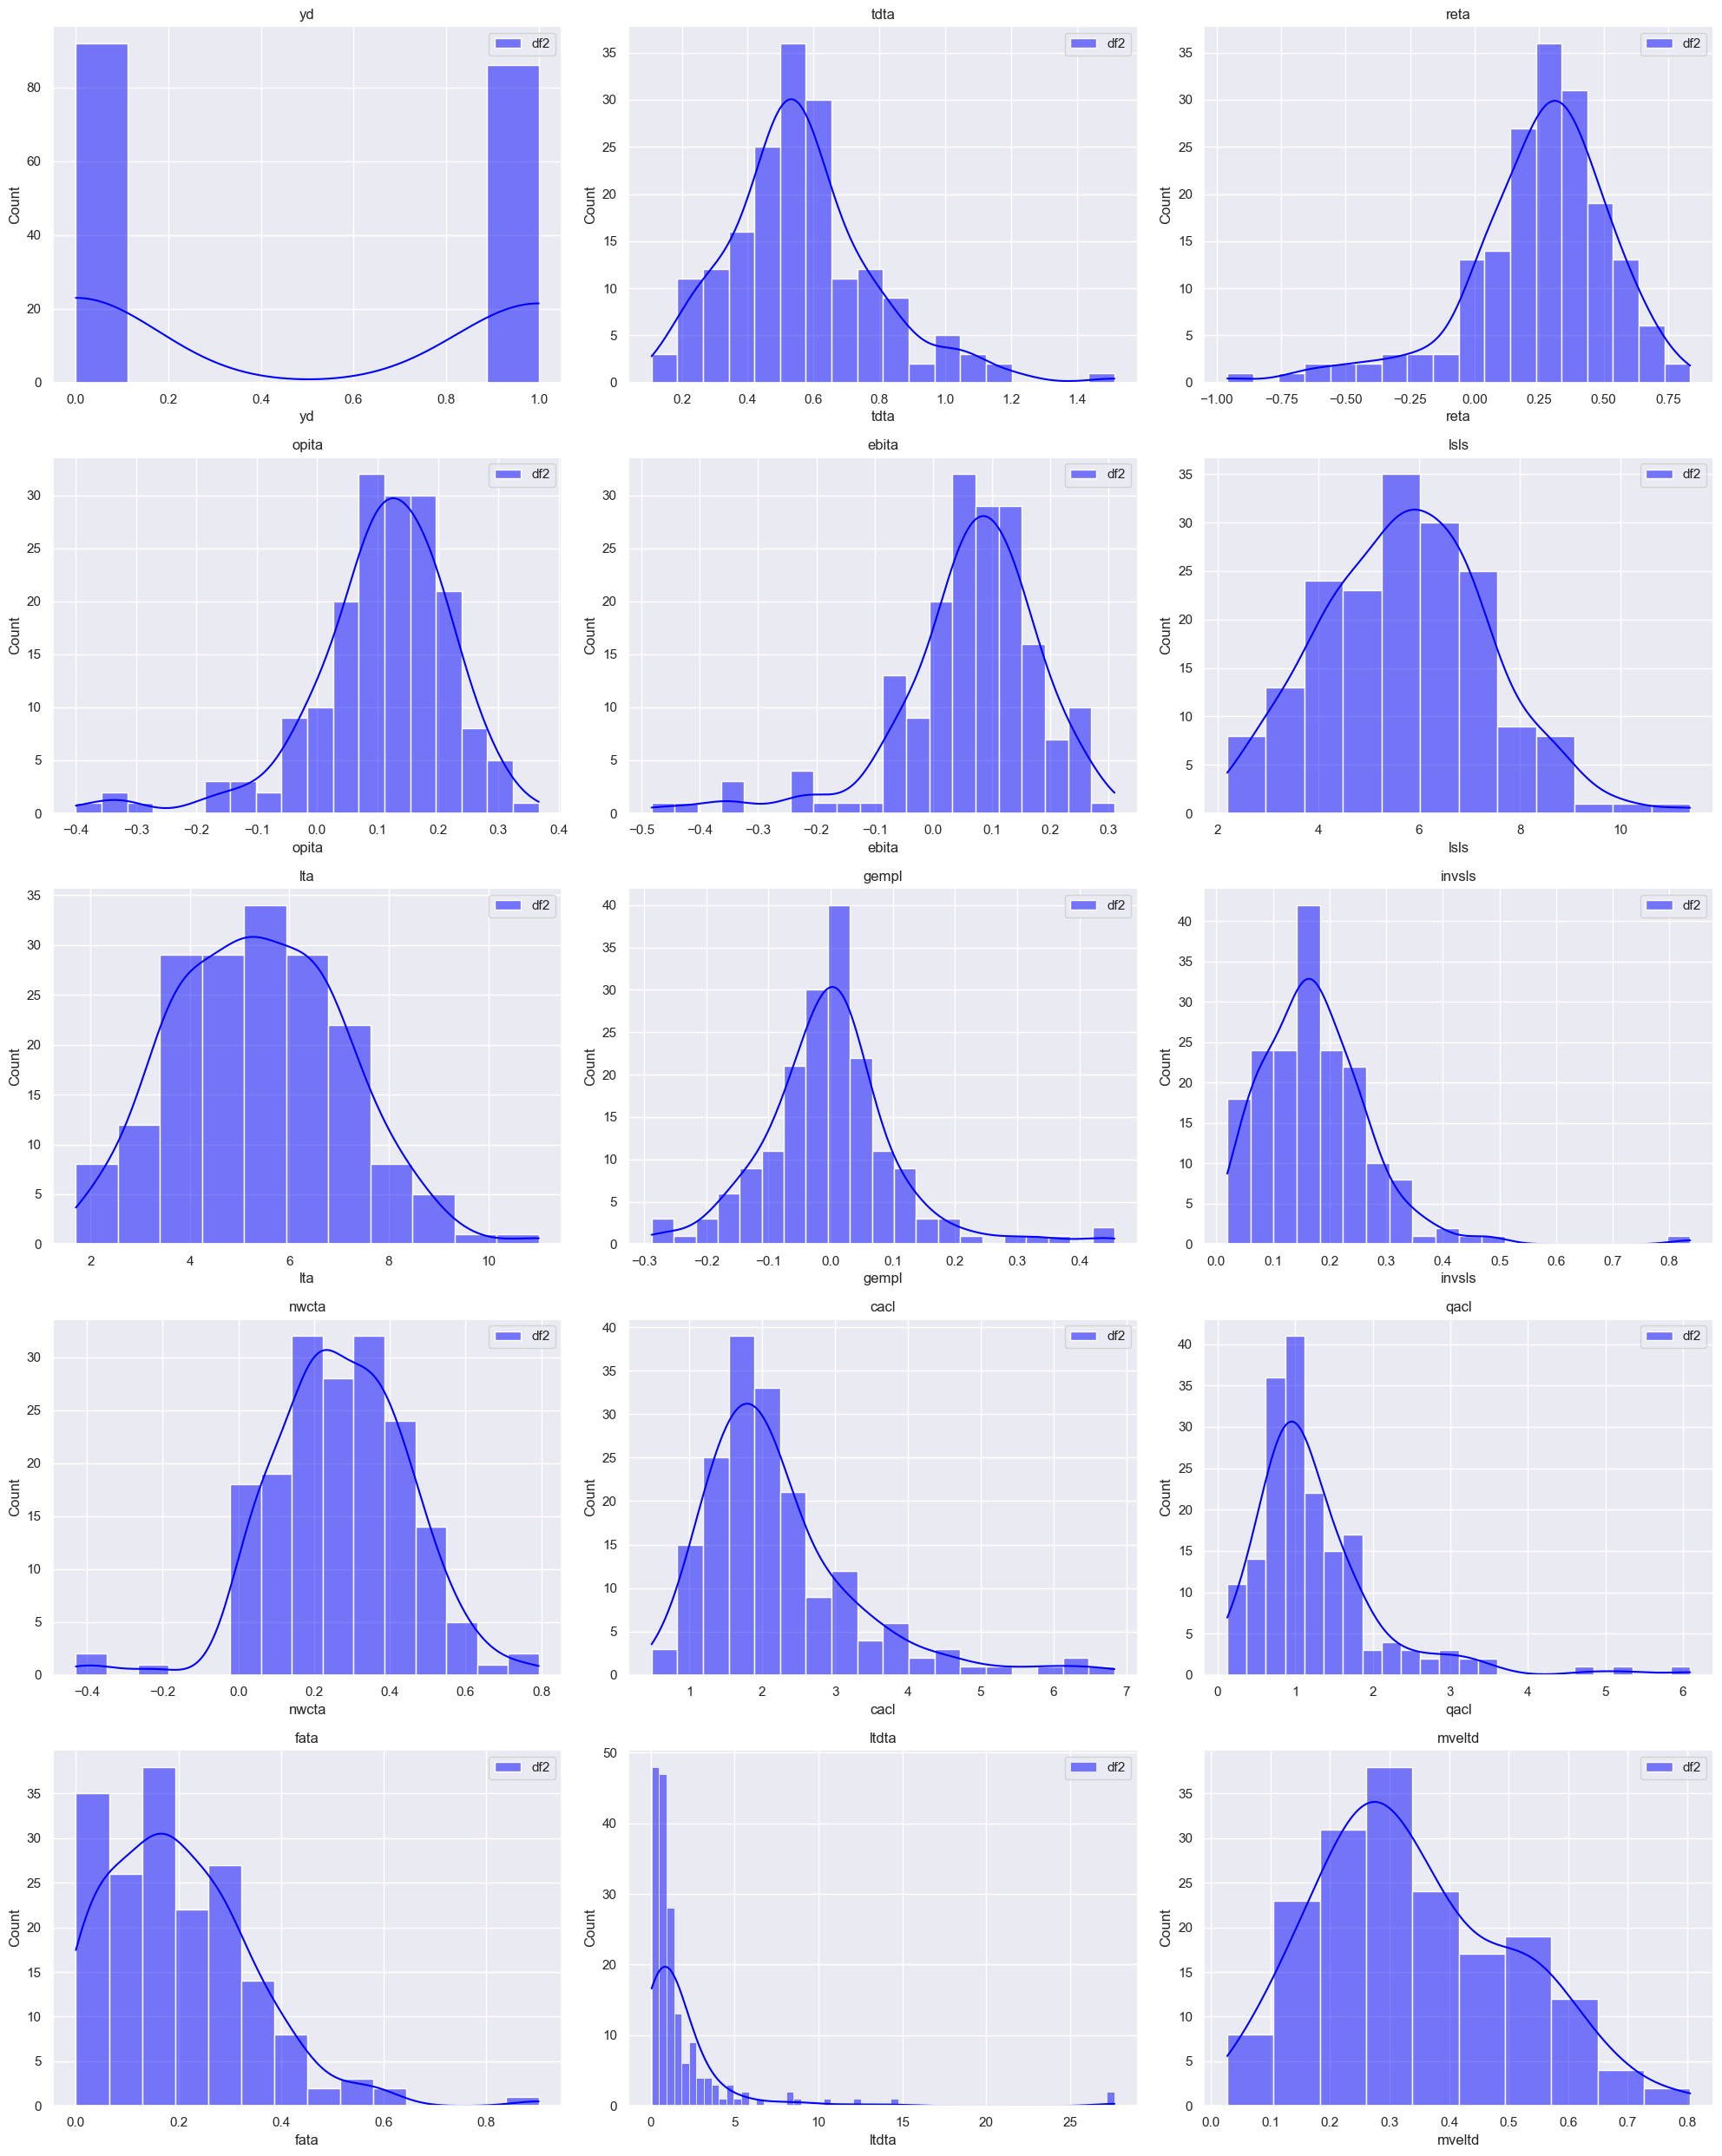

In [102]:
num_variables = len(df2.columns)
num_cols = 3
num_rows = -(-num_variables // num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

for i, variable in enumerate(df2.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]

    sns.histplot(df2[variable], ax=ax, color='blue', label='df2', kde=True)
    
    ax.set_title(variable)
    ax.legend()

for i in range(num_variables, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [103]:
descriptive = df2.describe()
descriptive.loc['skew', :] = stats.skew(df2)
descriptive.loc['kurtosis', :] = stats.kurtosis(df2, fisher=False)
descriptive.loc['stdev', :] = stats.tstd(df2)
descriptive.loc['median', :] = df2.median()
descriptive.loc[['count', 'mean', 'stdev', 'median', 'skew', 'kurtosis', 'min', '25%', '50%', '75%', 'max']]

,yd,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.483146,0.562252,0.249618,0.106238,0.063068,5.742953,5.380752,-0.001176,0.174965,0.270551,2.217071,1.252243,0.198835,1.860085,0.340637
stdev,0.501126,0.220998,0.280631,0.118264,0.124603,1.647569,1.675608,0.107679,0.099262,0.179032,1.076863,0.855767,0.144335,3.457018,0.164308
median,0.000000,0.541377,0.289108,0.115813,0.076922,5.720918,5.322813,-0.000984,0.163744,0.257236,1.986656,1.055156,0.181604,0.917732,0.313129
skew,0.067454,0.877158,-1.212709,-1.368002,-1.505602,0.250531,0.232920,0.902085,2.061892,-0.321166,1.727502,2.481112,1.067141,5.341980,0.442845
kurtosis,1.004550,4.731287,5.620072,6.500822,6.853229,3.115822,2.841949,6.426880,13.316426,4.409926,6.798946,11.940176,5.411894,37.042249,2.617446
min,0.000000,0.108258,-0.958997,-0.399538,-0.482151,2.192304,1.703244,-0.287979,0.019287,-0.429493,0.478824,0.122656,0.000000,0.052981,0.027201
25%,0.000000,0.434224,0.138658,0.059248,0.019488,4.476480,3.998169,-0.059087,0.107022,0.161803,1.553357,0.765283,0.089844,0.469880,0.226334
50%,0.000000,0.541377,0.289108,0.115813,0.076922,5.720918,5.322813,-0.000984,0.163744,0.257236,1.986656,1.055156,0.181604,0.917732,0.313129
75%,1.000000,0.656653,0.422183,0.181717,0.136110,6.801843,6.563133,0.040983,0.226532,0.391604,2.588153,1.479716,0.281938,1.729768,0.456083


While the datset does have 15 variables, in the code above I separated yd into its own database (y) to make it easier to provide descriptive statistics on the explanatory variables (x). The descriptive statistics for the 181 observations are provided in the above table. Before commenting on the univariate statistics, I wanted to remove the missing observations, leaving us with 178 observations.

Most of the means of the variables are positive and between 0 and 1. The only variable with a negative mean is 'gempl' (growth in employment). 'gempl' does not have any missing observations which are input as -99.99 so we cannot blame the negative mean on that. Also, we would expect healthy firms to have in general a positive growth of employment, so given that are data has more healthy firms than distressed, it is unexpected to see, on average, a negative growth in employment. The median is also negative. 

Skewness assesses the symmetry of the distribution of the variable. Positively skewed variables would have a skewness in excess of +2, and negatively skewed variables would have a skewness of lower than -2. The first notable variable is 'invsls', inventory/sales. The skew value of 2.06 indicates that there are values stretched out to the right of the distribution and suggests the existence of outliers. Both skewness and kurtosis are very sensitive to outliers, so an abnormally positive value can increase the skew. It is worth referencing the distribution graph above to visualise skewness. In sum, we have  inventory/sales (invsls), quick assets/liabilities (qacl) and long-term debt/assets (ltdta) indicating positive skew. ltdta shows skew of 5.34 and we can see very clearly observations stretching out to the right of the peak of the distribution. The only notable negatively skewed (but not significantly so) variable is ebita (pre tax earnings/assets) with a skew of -1.5. Skewness is important to address because it can deteriorate the quality of linear models.

Kurtosis assesses how peaked the distribution is. In other words, how concentrated the distribution is. We follow the same rule for +2 and -2 kurtosis being notable. Almost variables except the binary 'yd' are leptokurtic, displaying steeper distributions than the normal. Most notable is that of long-term debt/assets, which is extremely concentrated around 0 (again, see the graph above).

## Comparing the train and test

In [104]:
#Removing the missing observations (the -99.99s) from the x and ys
def drop_missing(x, y, variable, threshold, mode='<'):
    if mode == '<':
        to_drop = x[x[variable] < threshold].index
    elif mode == '>':
        to_drop = x[x[variable] > threshold].index
    return x.drop(index=to_drop), y.drop(index=to_drop)

x_train, y_train = drop_missing(x_train, y_train, 'fata', 0, '<')
x_test, y_test = drop_missing(x_test, y_test, 'fata', 0,  '<')
x_train, y_train = drop_missing(x_train, y_train, 'ltdta', 0, '<')
x_test, y_test = drop_missing(x_test, y_test, 'ltdta', 0,  '<')

x, y = drop_missing(x, y, 'fata', 0,  '<')
x, y = drop_missing(x, y, 'ltdta', 0, '<')


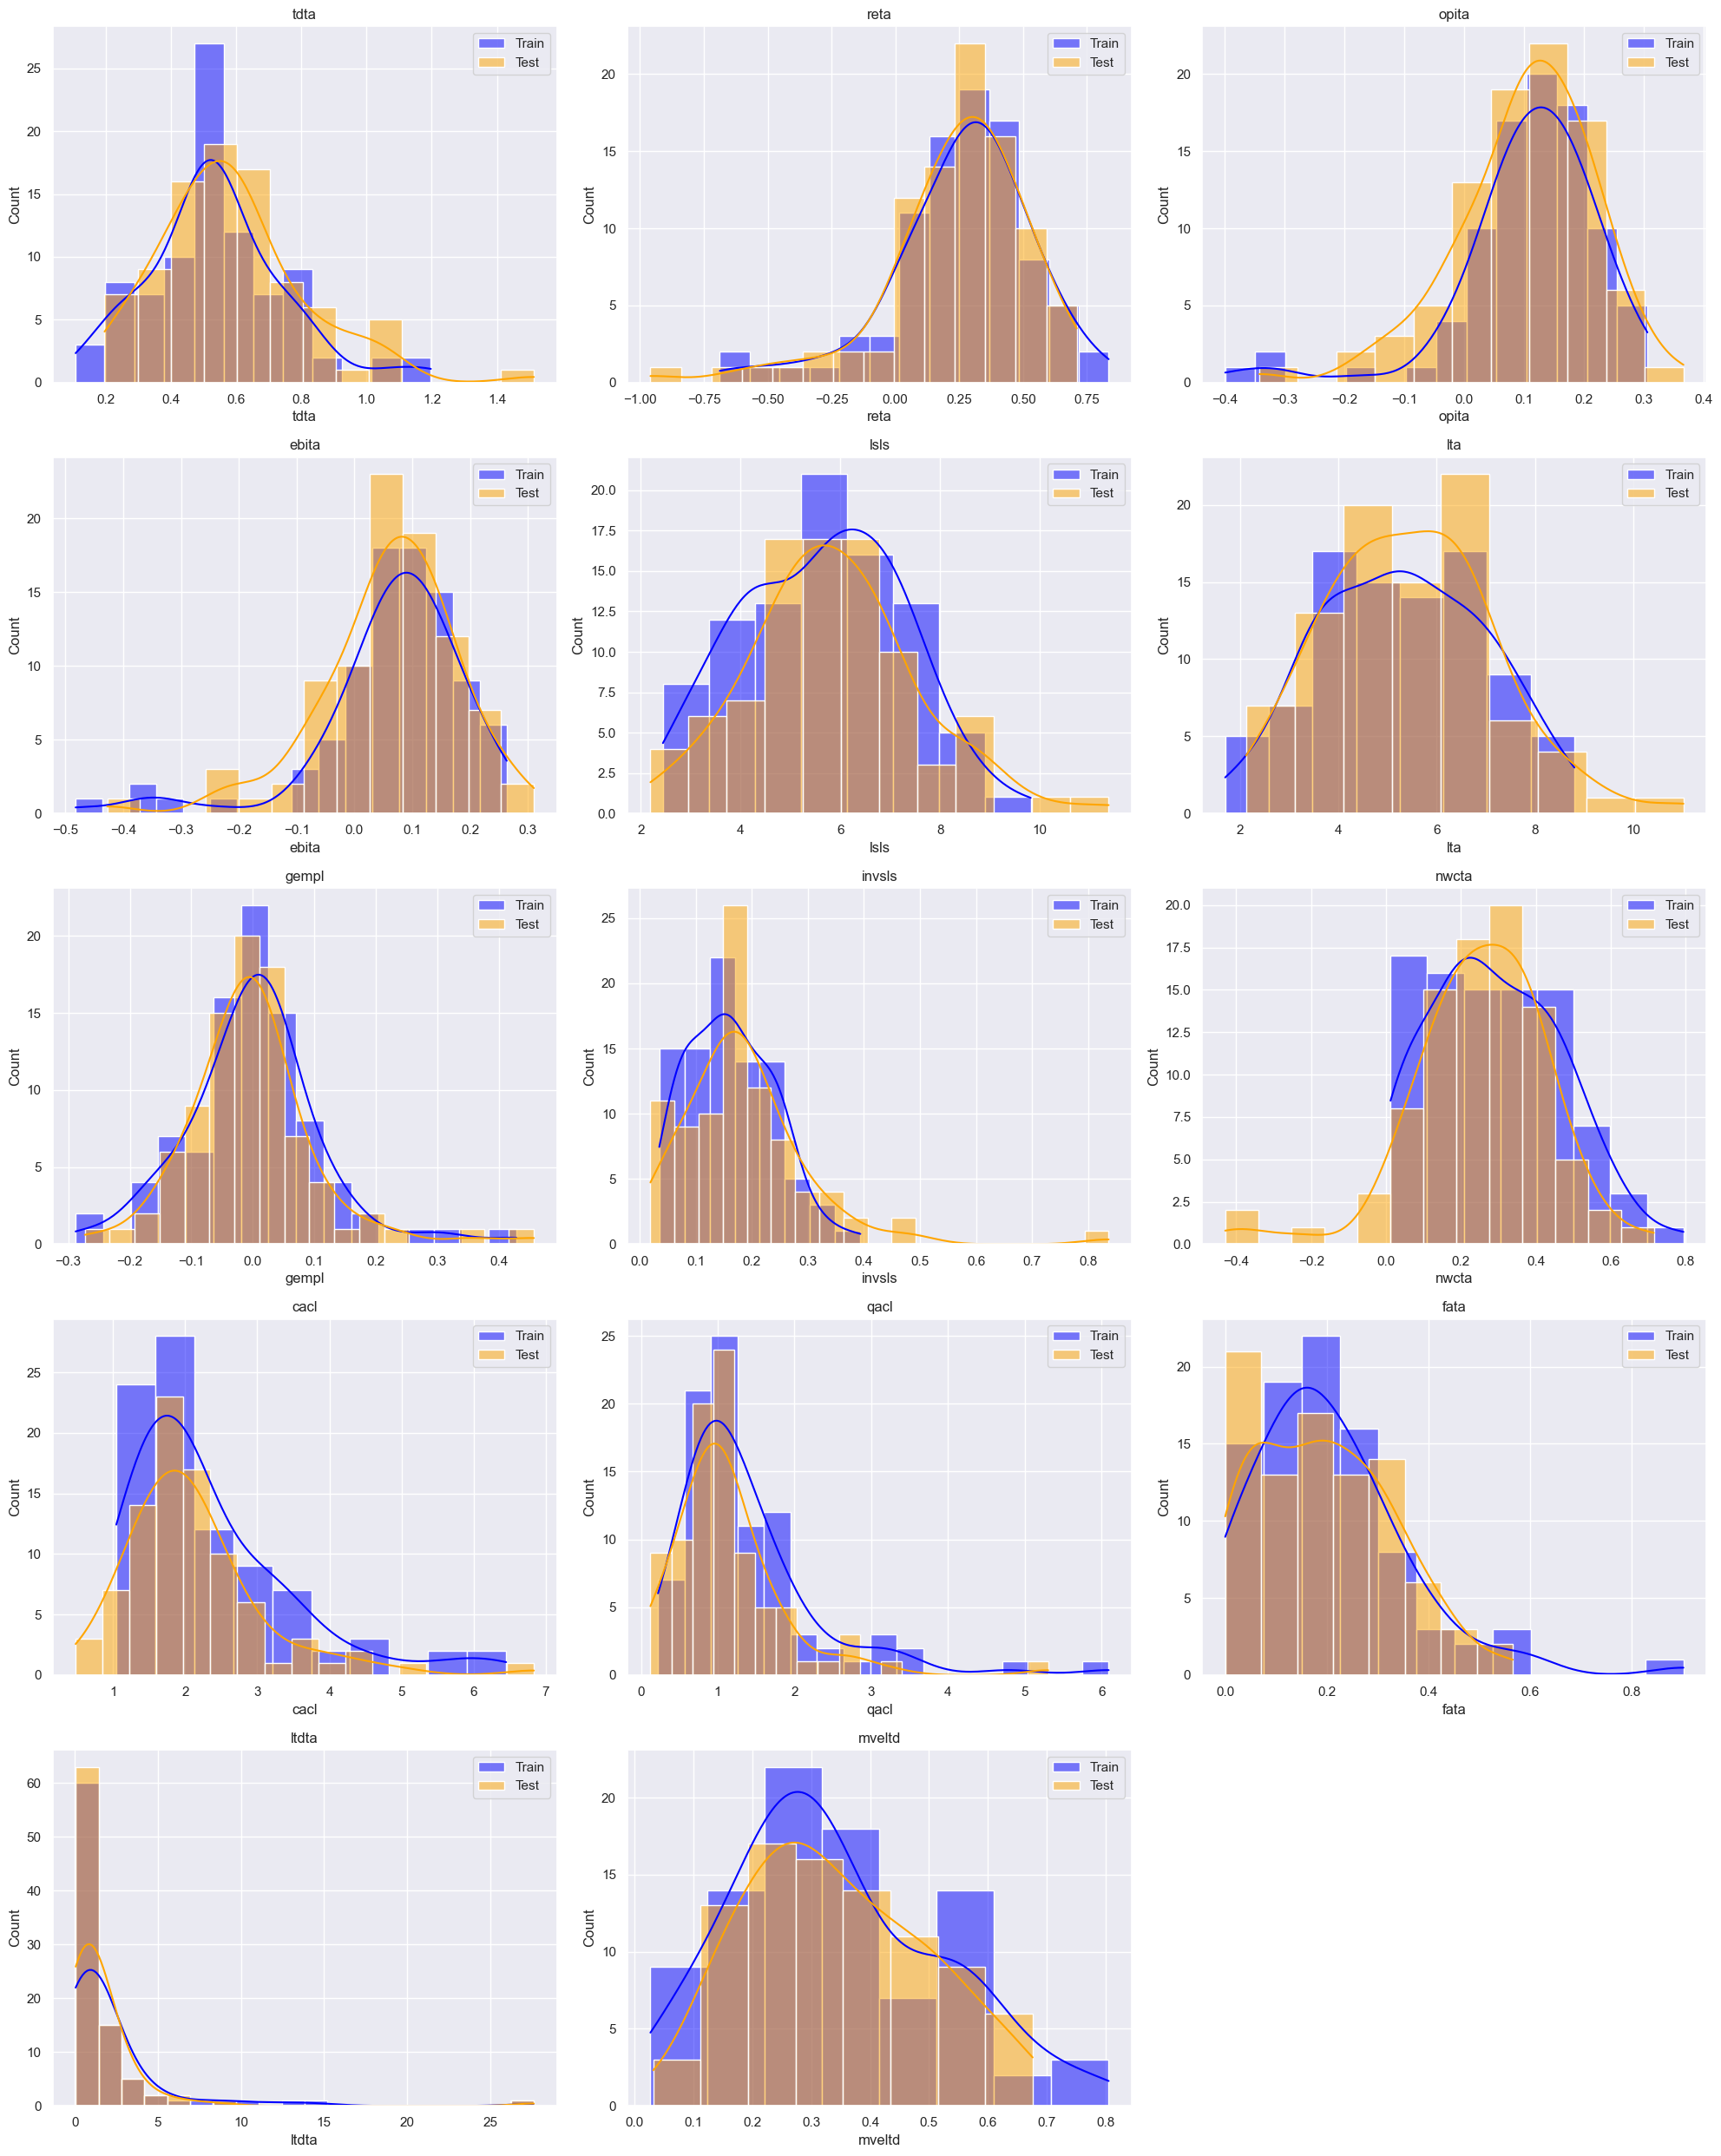

In [105]:
num_variables = len(x_train.columns)
num_cols = 3
num_rows = -(-num_variables // num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5*num_rows))

for i, variable in enumerate(x_train.columns):
    row_index = i // num_cols
    col_index = i % num_cols
    ax = axes[row_index, col_index]
    
    if variable == 'ltdta':
        # Make the ltdta histogram wider
        sns.histplot(x_train[variable], ax=ax, color='blue', label='Train', kde=True, bins=20)
        sns.histplot(x_test[variable], ax=ax, color='orange', label='Test', kde=True, bins=20)
    else:
        sns.histplot(x_train[variable], ax=ax, color='blue', label='Train', kde=True)
        sns.histplot(x_test[variable], ax=ax, color='orange', label='Test', kde=True)
    
    ax.set_title(variable)
    ax.legend()

for i in range(num_variables, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

We can see the outlier results, or rather the missing observations that were filled in with -99.9 are spoiling our comparisons. The same goes for fixed assets / total assets ("fata"). We have removed these observations from the 'df' dataframe, but let us remove those observations from our train and test dataframes and re-plot. For the rest of the variables though, things are looking promising. Given that we only have 178 remaining observations and we split these into train and test the distributions are fairly similar. This is a promising sight and gives us confidence that our test and train dataframes are fairly well matched. 

Now we have removed the missing observations. Observation of the table above does remain to give us some cause for concern. Skewness and Kurtosis are very sensitive to outliers, and we should be troubled about the value of ltdta = 27.44416. There is a similar maximum value in our test dataframe, ltdta = 27.631832. For now, we will keep these observations. We can drop later if we see the results of the model being too disturbed by their inclusion.

In [106]:
two_sigma = x['ltdta'].mean() + x['ltdta'].std()*2
x[x['ltdta'] > two_sigma]

,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd
1,0.196958,0.011139,0.221797,0.200671,4.025514,3.827649,0.205517,0.158391,0.595541,4.319132,3.243222,0.001032,27.631832,0.162987
24,0.293612,0.232368,0.258011,0.207032,4.733112,4.582674,0.428108,0.169831,0.534509,3.221926,2.401336,0.053051,12.474924,0.214703
46,0.254665,0.361590,0.227870,0.176469,6.815121,6.746934,0.097728,0.089151,0.512323,3.584032,3.102648,0.009318,10.365155,0.261363
52,0.145539,0.383244,0.249250,0.240580,2.832563,3.196006,0.105342,0.075232,0.793606,6.452848,6.093447,0.000000,27.604182,0.027201
92,0.207705,0.701603,0.293906,0.249679,5.591193,5.322981,0.028347,0.060723,0.182932,2.286423,1.728043,0.002650,14.511942,0.543027


These are the two observations that have problematic values of ltdta that contribute to the significant positive skew on the distribution graphs and the descriptive statistic tables. I identified these observations by displaying observations where ltdta is more than two standard deviations from the mean, a 'rule of thumb' for classifying outliers.

### 3. Comment on the histograms of tdta for default vs healthy firms.

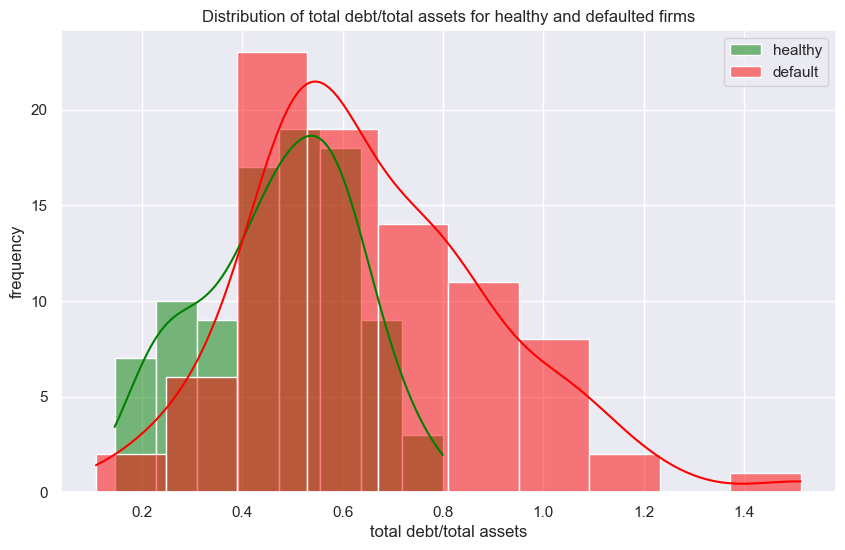

In [107]:
#creating new dataframes for healthy and default
tdta_healthy = df2[df2['yd'] == 0]['tdta']
tdta_default = df2[df2['yd'] == 1]['tdta']

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(tdta_healthy, color='green', label='healthy', kde=True, ax=ax)
sns.histplot(tdta_default, color='red', label='default', kde=True, ax=ax)

ax.set_xlabel('total debt/total assets')
ax.set_ylabel('frequency')
ax.set_title('Distribution of total debt/total assets for healthy and defaulted firms')
ax.legend()

plt.show()

In [108]:
tdta_default_stats = tdta_default[:].describe()
tdta_healthy_stats = tdta_healthy[:].describe()

stats_df = pd.DataFrame({
    'Default': tdta_default_stats,
    'Healthy': tdta_healthy_stats
})

stats_df = stats_df.transpose()

print(stats_df)

         count      mean      std       min       25%       50%       75%  \
Default   86.0  0.657788  0.24403  0.108258  0.500904  0.603087  0.811819   
Healthy   92.0  0.472946  0.15061  0.145539  0.362260  0.486091  0.587014   

              max  
Default  1.512991  
Healthy  0.799714  


The histogram above seems to show defaulting firms with slightly higher total debt/total assets. We can confirm this with the statistical table presented above, with defaulting firms on average having a total debt/total assets ratio 0.2 higher than healthy firms.

Healthy firms are much more concentrated on the lower end and are less skewed, contained within the range 0.14 to 0.80. Defaulting firms, on the other hand, are much more skewed and appear to have a much more abnormal distribution. The range is much larger for defaulting firms: 0.11 to 1.51, and it is only defaulting firms that have a total debt/total assets ratio exceeding 1. There is a positive skew, with some possible outliers at the high values of >1. Indeed, defaulting firms not only have higher means, but despite the lower minimum value, the every other quartile, including median, is higher. Hence, we can conclude that defaulting firms exhibit a greater range, and the lowest total debt/total asstes firm did indeed default, but in general defaulting firms have higher debt/assets ratios than healthy firms.

In terms of kurtosis, both healthy and defaulting firms appear to be leptokurtic, defaulting firms more so, with a high concentration of observations around the mean for both healthy and defaulting firms.

### 4. What are the results of the normality test for tdta for default vs healthy firms.

In [109]:
print(f'Jarque-Bera Test of Normality: \n   H0: Normal Distribution \n   Healthy P-value: {stats.jarque_bera(tdta_healthy)[1]:0.3f} \n   Defaulted P-value: {stats.jarque_bera(tdta_default)[1]:0.3f}')



Jarque-Bera Test of Normality: 
   H0: Normal Distribution 
   Healthy P-value: 0.244 
   Defaulted P-value: 0.010


The Jarque-Bera test tests whether a distribution has the skewness and kurtosis of a normal distribution. The JB statistic is defined as 

$$
JB = \frac{n}{6} (s^2 + \frac{1}{4}(k-3)^2)) 
$$

where n is the number of observations, s is the sample skewness, and k the kurtosis.
The null hypothesis is both the skewness being 0 and the kurtosis being 0. The p-value for healthy does not allow rejection of the null hypothesis, so we accept that tdta for healthy firms is normally distributed. For defaulted firms, however, we can reject the null hypothesis with almost 99% confidence. This means the distribution for tdta for defaulted firms is not normally distributed.
This test of skewness and kutosis is much the same as the 'sktest' of normality in Stata.

In [110]:
print(f'Shapiro-Wilks Test of Normality: \n   H0: Normal Distribution \n   Healthy P-value: {stats.shapiro(tdta_healthy)[1]:0.3f} \n   Defaulted P-value: {stats.shapiro(tdta_default)[1]:0.3f}')



Shapiro-Wilks Test of Normality: 
   H0: Normal Distribution 
   Healthy P-value: 0.110 
   Defaulted P-value: 0.016


The Shapiro-Wilks test tests whether the data has been generated from a normal distribution (null hypothesis). The story is much the same as for the JB test. We cannot reject the null for healthy firms, suggesting tdta is normally distributed for them, but we can reject the null for defaulting firms with almost as high a confidence as with the JB test, leading us to believe that tdta for defaulting firms is not normally distributed.

In [111]:
print(f'D’Agostino and Pearson Test of Normality: \n   H0: Normal Distribution \n   Healthy P-value: {stats.normaltest(tdta_healthy)[1]:0.3f} \n   Defaulted P-value: {stats.normaltest(tdta_default)[1]:0.3f}')



D’Agostino and Pearson Test of Normality: 
   H0: Normal Distribution 
   Healthy P-value: 0.112 
   Defaulted P-value: 0.009


The D’Agostino and Pearson Test of Normality is a goodness of fit measure of departure from normality. The null hypothesis is that the datapoints are independent and identically distributed Gaussian variables. The conclusions are the same: we do not reject for healthy firms, suggesting normality, but we do reject for defaulted firms with >99% confidence: suggesting tdta for defaulted firms is not normally distributed.

In [112]:
print(f'Kolmogorov-Smirnov Test: \n H0: equivalent distribution \n Test statistic: {stats.ks_2samp(tdta_healthy, tdta_default)[1]:0.3f} \n P-value: {stats.ks_2samp(tdta_healthy, tdta_default)[1]:0.3f}')



Kolmogorov-Smirnov Test: 
 H0: equivalent distribution 
 Test statistic: 0.000 
 P-value: 0.000


The Kolmogorov-Smirnov test is slightly different and has a null hypothesis that the distributions of tdta for healthy and defaulted firms is equivalent. We can reject the null hypothesis that the distribution of tdta for healthy and defaulted firms is equivalent with >99% confidence.

### 5. What is the value of Students t-statistics related to the test of equality of mean of tdta between each group? Check that it is the same for three other students tests described in the course. Can you detail which are the four null hypotheses in each of these cases?


#### Student's t-test of equivalence of means (test 1 in slides)

In [113]:
print(f'Students equivalence of means T-Test: \n H0: mean_healthy - mean_default = 0 \n Test statistic: {stats.ttest_ind(tdta_healthy, tdta_default)[0]:0.3f} \n P-value: {stats.ttest_ind(tdta_healthy, tdta_default)[1]:0.3f}')
print(f" mean of healthy: {tdta_healthy.mean()} \n mean of default: {tdta_default.mean()} \n difference: {tdta_healthy.mean() - tdta_default.mean()}")



Students equivalence of means T-Test: 
 H0: mean_healthy - mean_default = 0 
 Test statistic: -6.124 
 P-value: 0.000
 mean of healthy: 0.4729464652173913 
 mean of default: 0.6577883860465116 
 difference: -0.18484192082912027


The nul hypothesis of this test asserts that the mean tdta of healthy and defaulting firms is equal. In other words, that the mean of tdta for healthy firms - mean of tdta for default firms is 0. If there is no difference between the means of the two groups, then the difference will indeed be 0 and the null-hypothesis will not be rejected. The test statistic is -6.124, well in excess of the -2.58 required for a 99% confident rejection of the null hypothesis. The p-value is 0.000. Therefore, we can strongly reject the hypothesis of the means being equivalent. We have different means here.

The core idea of scoring is discriminating between the two groups (slide 93), so being able to reject the equivalence of means is central to having a model that can effectively discriminate between healthy and defaulting firms using the ratios that are our explanatory variables. To minimise type 1 (false positive) and type 2 (false negative) errors we are looking for ratios, like tdta, that are not equivalent for both healthy and defaulting firms, because they will not allow discrimination between the two.

#### Linear Regression: Student's test on parameter β (test 2 in slides)

This test is much the same as the one below. We regress tdta (our - now -  dependent variable) on default (our  - now - explanatory variable). If β is significant, it means that default has a statistically significant effect on total debt/total assets, and we can accept the alternative hypothesis (β≠0).

$$
tdta_i = α + β*yd_i + ε_i
$$


In [114]:
model = sm.regression.linear_model.OLS(x['tdta'], sm.add_constant(y), hasconst=True).fit()
print('T-Test Recovered from Linear Probability Regression: x = α + βy + ϵ')
print('H0: β = 0')
print(f'T-statistic: {model.tvalues[1]:0.3f}')
print(f'P-value: {model.pvalues[1]:0.3f}')
print(model.summary())

T-Test Recovered from Linear Probability Regression: x = α + βy + ϵ
H0: β = 0
T-statistic: 6.124
P-value: 0.000
                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        11:24:59   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

The p-value for β is 0.000. Therefore, we reject the null hypothesis that the coefficient on yd as an explanatory variable of tdta is 0. We accept the alternative hypothesis that yd does have an effect on tdta and β≠0. Hence, we are led to believe again that there is a difference in means between the two groups.

And sure enough, the constant is the mean total debt/total assets for non defaulting firms, and the constant + the coefficient on yd is the mean tdta for defaulting firms.

In [115]:
df2.loc[df2['yd'] == 0, 'tdta'].mean()

0.4729464652173913

In [116]:
df3.loc[df3['yd'] == 1, 'tdta'].mean()

0.6577883860465116

#### Linear regression: Student's test on parameter β' (test 3 in slides)

In [117]:
model = sm.regression.linear_model.OLS(y, sm.add_constant(x['tdta']), hasconst=True).fit()
print("T-Test Recovered from Linear Probability Regression: y = α' + β'x + ϵ")
print("H0: β' = 0")
print(f'T-statistic: {model.tvalues[1]:0.3f}')
print(f'P-value: {model.pvalues[1]:0.3f}')
print(model.summary())

T-Test Recovered from Linear Probability Regression: y = α' + β'x + ϵ
H0: β' = 0
T-statistic: 6.124
P-value: 0.000
                            OLS Regression Results                            
Dep. Variable:                     yd   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        11:25:01   Log-Likelihood:                -111.90
No. Observations:                 178   AIC:                             227.8
Df Residuals:                     176   BIC:                             234.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------

This model regresses y (which is default (yd=1) or not default (yd=0)) on x (total debt/total assets). 

$$
yd_i = α + β*tdta_i + ε_i
$$

Interpretation of this regression relies on the significance of the β coefficient. If the β coefficient is significant, then we can conclude that tdta is a reliable predictor of default. This also means that the tdta is an effective discriminator of default - the mean of tdta for default and healthy firms is different. The p-value is 0.000 so we can reject the null hypothesis that β = 0 and accept the alternative hypothesis that β ≠ 0 which implies a significant difference in means of the healthy and defaulting firms.

#### Test of correlation (test 4 in slides)

Student's test for HO: r (yd, tdta)=0 in correlation matrix.

In [118]:
correlation_matrix = y.corr(x['tdta'])
print(correlation_matrix)
pear = stats.pearsonr(y, x['tdta'])[0]
pval = stats.pearsonr(y, x['tdta'])[1]
print(f"Pearson's R: {pear:0.4f}")
print(f"P-value: {pval:0.4f}")

0.4191399039926984
Pearson's R: 0.4191
P-value: 0.0000


We can use Pearson's R to test the correlation of yd and tdta. 
Pearson's R is

$$
r = \frac{Σ(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{(x_i - \bar{x})^2 (y_i - \bar{y})^2}}
$$


The p-value is again 0.000, so the null-hypothesis that the correlation betwen yd and tdta (as calculated with Pearson's R) is zero can be rejected. In other words, we accept the alternative that r ≠ 0.

#### ANOVA (Analysis of Variance)

ANOVA tests whether there is variance in the means of two groups. The null hypothesis is that the group means are equal (no variance between the means). To do this, we regress tdta on yd and perform the one-way ANOVA test.


In [119]:
from statsmodels.stats.api import anova_lm
model = sm.OLS(x['tdta'], sm.add_constant(y), hasconst=True).fit()
f_statistic, p_value = stats.f_oneway(tdta_healthy, tdta_default)
alpha = 0.05
print(f'the p-value is {p_value:0.3f}')
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant variation in means.")
else:
    print("Fail to reject the null hypothesis. There is no significant variation in means.")

the p-value is 0.000
Reject the null hypothesis. There is a significant variation in means.


We reject the null hypothesis that there is no difference in means. There is variance in the means of tdta of the two groups so the null hypothesis is again rejected with >99% confidence.

###### All of the tests performed above support the same conclusion: tdta is an effective variable to discriminate between healthy and defaulted firms. They are also conducted using the entire 178 observations - not just the train dataset which we will use later for model training.

### 6.Bivariate correlations with the dependent variable : Present a table sorting the 14 ratios by their correlation with the dependent variable (or equivalently by the t-statistics of the test of difference of means). Which are the explanatory variables most correlated with the dummy for default? Are there some of them with simple correlations below 0.1 in absolute value?

In [120]:
from tabulate import tabulate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
correlation_table = pd.DataFrame(columns=['Variable', 'Correlation'])

for variable in x.columns:
    correlation, p_value = stats.pearsonr(y, x[variable])
    t_value = correlation * ((len(y) - 2) / ((1 - correlation**2) ** 0.5))
    p_value = round(p_value, 3)
    correlation_table = correlation_table.append({
        'Variable': variable,
        'Correlation': correlation,
        't-value': t_value,
        'p-value': p_value
    }, ignore_index=True)

correlation_table = correlation_table.sort_values(by='Correlation', ascending=False)

print(print(tabulate(correlation_table, headers='keys', tablefmt='simple')))

    Variable      Correlation    t-value    p-value
--  ----------  -------------  ---------  ---------
 0  tdta             0.41914     81.25        0
 7  invsls           0.169591    30.2867      0.024
11  fata             0.149815    26.6684      0.046
10  qacl            -0.135133   -24.0035      0.072
 8  nwcta           -0.137055   -24.3514      0.068
 5  lta             -0.150413   -26.7774      0.045
13  mveltd          -0.16482    -29.4106      0.028
 4  lsls            -0.16797    -29.9887      0.025
 9  cacl            -0.172408   -30.8051      0.021
12  ltdta           -0.250152   -45.4724      0.001
 6  gempl           -0.304482   -56.2601      0
 3  ebita           -0.377183   -71.6785      0
 1  reta            -0.405487   -78.0721      0
 2  opita           -0.411487   -79.4606      0
None


The most correlated variable with yd is tdta. We looked at this variable above and showed the strength of this variable as a predictor using the difference of means tests. The p-value is zero for tdta (which we have also seen).

invsls (inventory / sales) is the next most strongly positively correlated variable with the binary-dependent default variable. Howewer, the p-value is not as small, so we cannot reject the null hypothesis of corr=0 at 99% confidence, only 95% confidence. It is a similar story for fata (fixed assets/total assets).

The variables other than tdta which are the most strongly correlated with default are negatively correlated. opita (income/assets), reta (retained earnings) and ebita (pre-tax earnings/assets) are the next most strongly correlated variables (in that order) with p-values of 0.000 and Pearson's R values of around 4.

There are no variables with simple correlations below 0.1 in absolute value, with the least correlated variable being qacl (quick assets/liabilities). This is a very 'close horizon' ratio and may change quickly which perhaps explains why it is not very good at predicting default.

Furthermore, the only other worrying thing about those variables in the middle of the table above is the p-valus. All pass the 90% confidence threshold, but qacl and nwcta (net working capital/assets) fail at the 95% threshold and invsls (inventory/sales), fata (fixed assets/total assets), lta (log assets), mveltd (market value equity/long-term debt), lsls (log sales) and cacl (current assets/liabilities) fail at the 99% threshold.


### 7. Compare and comment briefly the box-plots of each of the two groups of firms for the 14 financial ratios. The larger the difference of means, the more discriminant is the ratio.

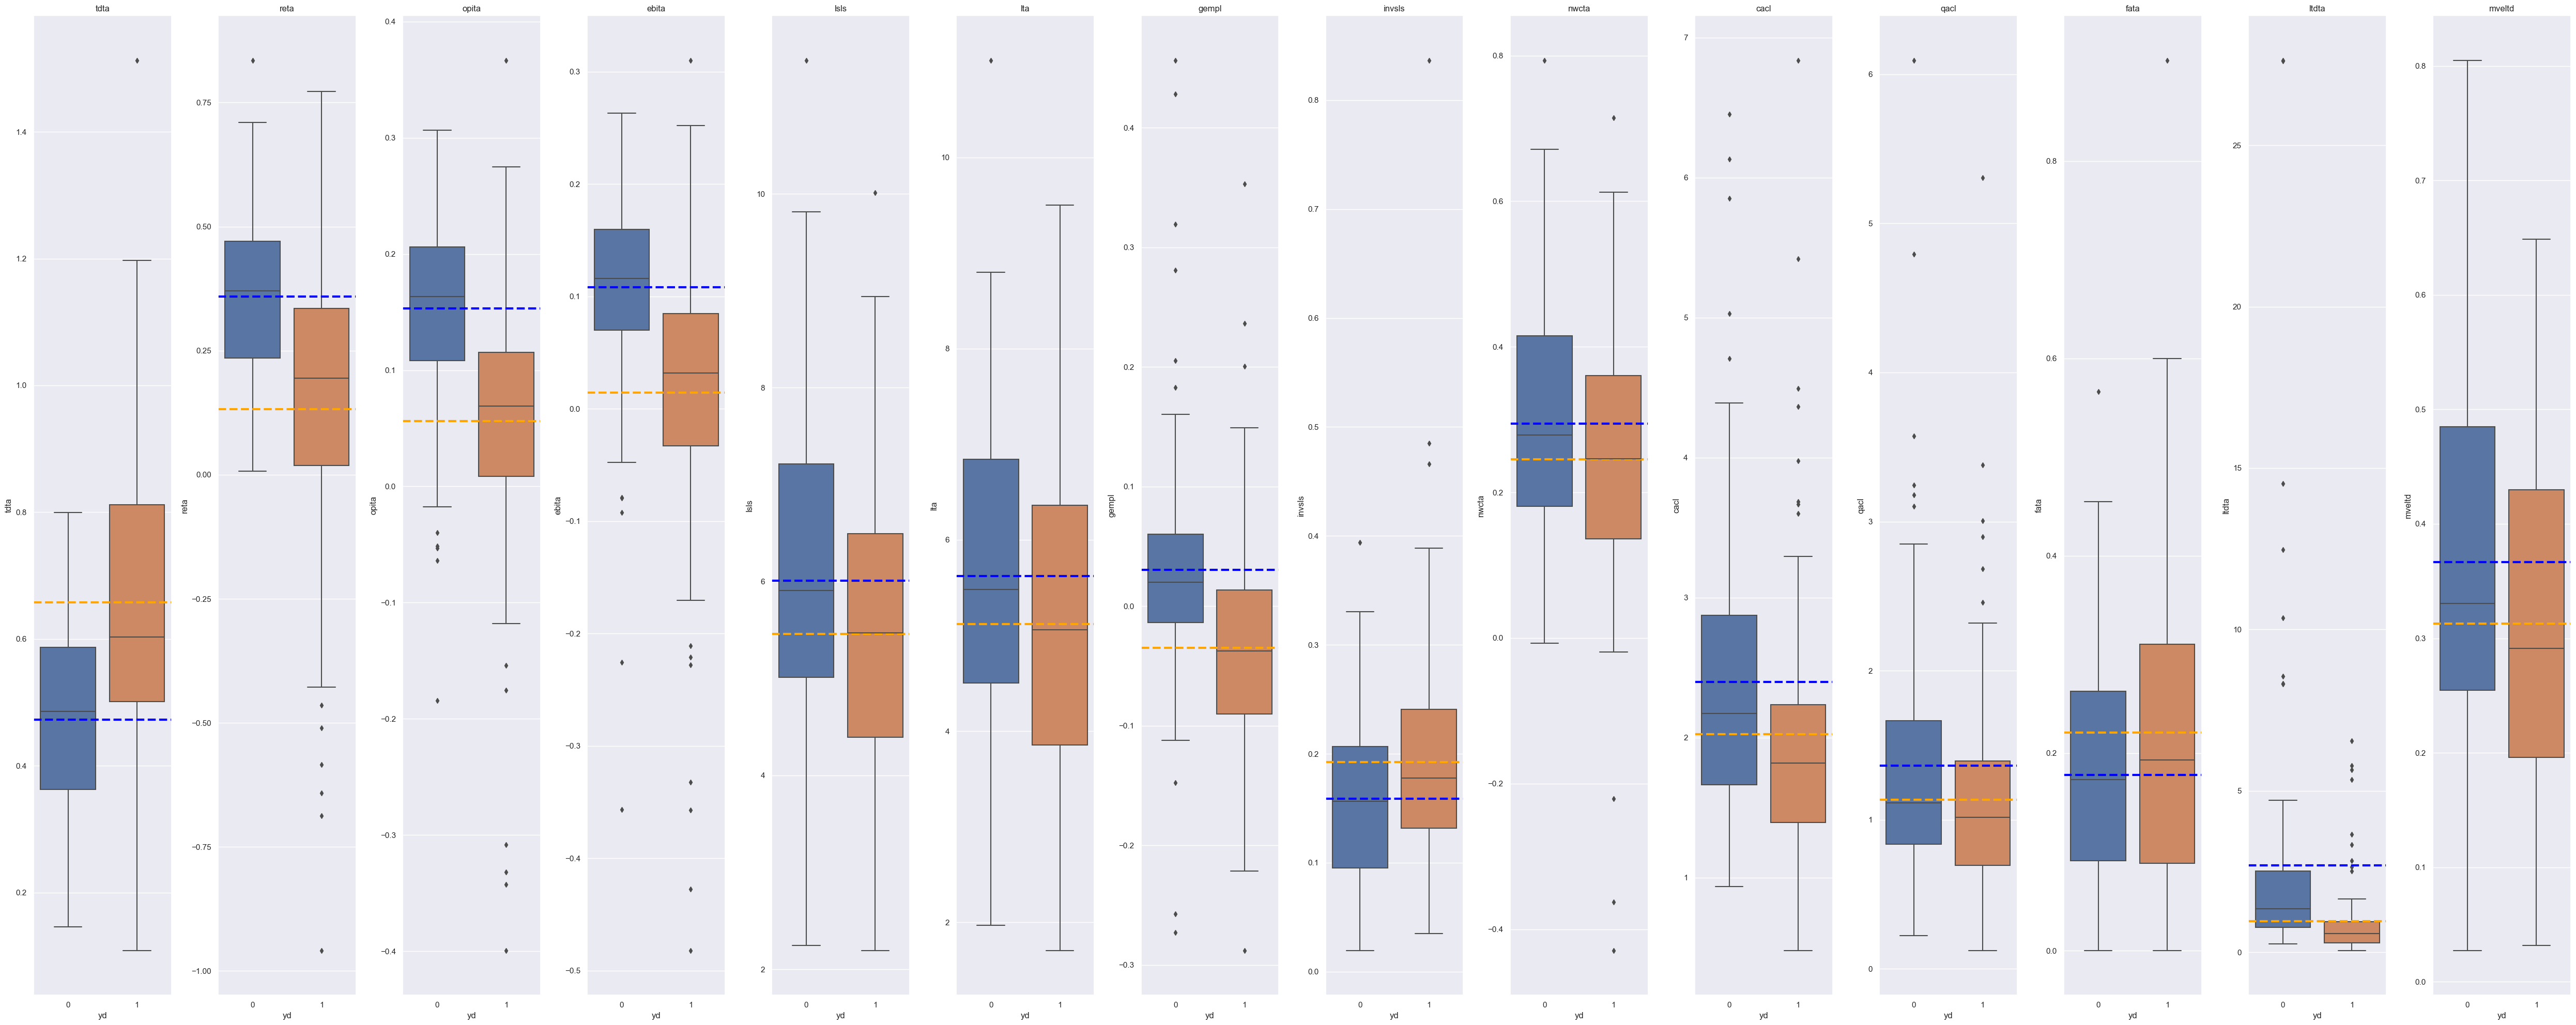

Means are the dashed lines


In [121]:
combined_df = pd.concat([x, y], axis=1)
fig, axes = plt.subplots(nrows=1, ncols=14, figsize=(50, 20))
for i, variable in enumerate(x.columns):
    ax = sns.boxplot(x='yd', y=variable, data=combined_df, ax=axes[i])
    mean = combined_df.groupby(['yd'])[variable].mean()
    ax.axhline(mean[0], color='blue', linestyle='--', label='Mean yd=0', linewidth=3)
    ax.axhline(mean[1], color='orange', linestyle='--', label='Mean yd=1', linewidth=3)
    ax.set_title(f'{variable}')
    ax.set_xlabel('yd')
    ax.set_ylabel(variable)
    
plt.tight_layout()
plt.show()
print('Means are the dashed lines')

From the correlation values above, we should expect to see the difference of means for tdta, opita, reta and obita to be the most pronounced. Indeed, this is the case. The lines in the centre of the bodies of the boxplots represent the median and the dashed lines represent the means. We can see the largest difference between the means for these variables relative to the scale, and this suggests they will be the strongest predictors of default in the models we will compose later.

As we look through the boxplots, some variables have very similar means for defaulted and healthy firms. These are also the variables with the largest overlaps of the boxplots. When the boxplots overlap, there is less discrimination between defaulted and healthy firms and the predictive power is less.

### 8. Bivariate correlation between explanatory variables (regressors): Are there explanatory variables with simple correlation coefficient with other explanatory variables larger than 0.8 ? Is it expected and explained by accounting properties? Will you include all of them in your regressions?

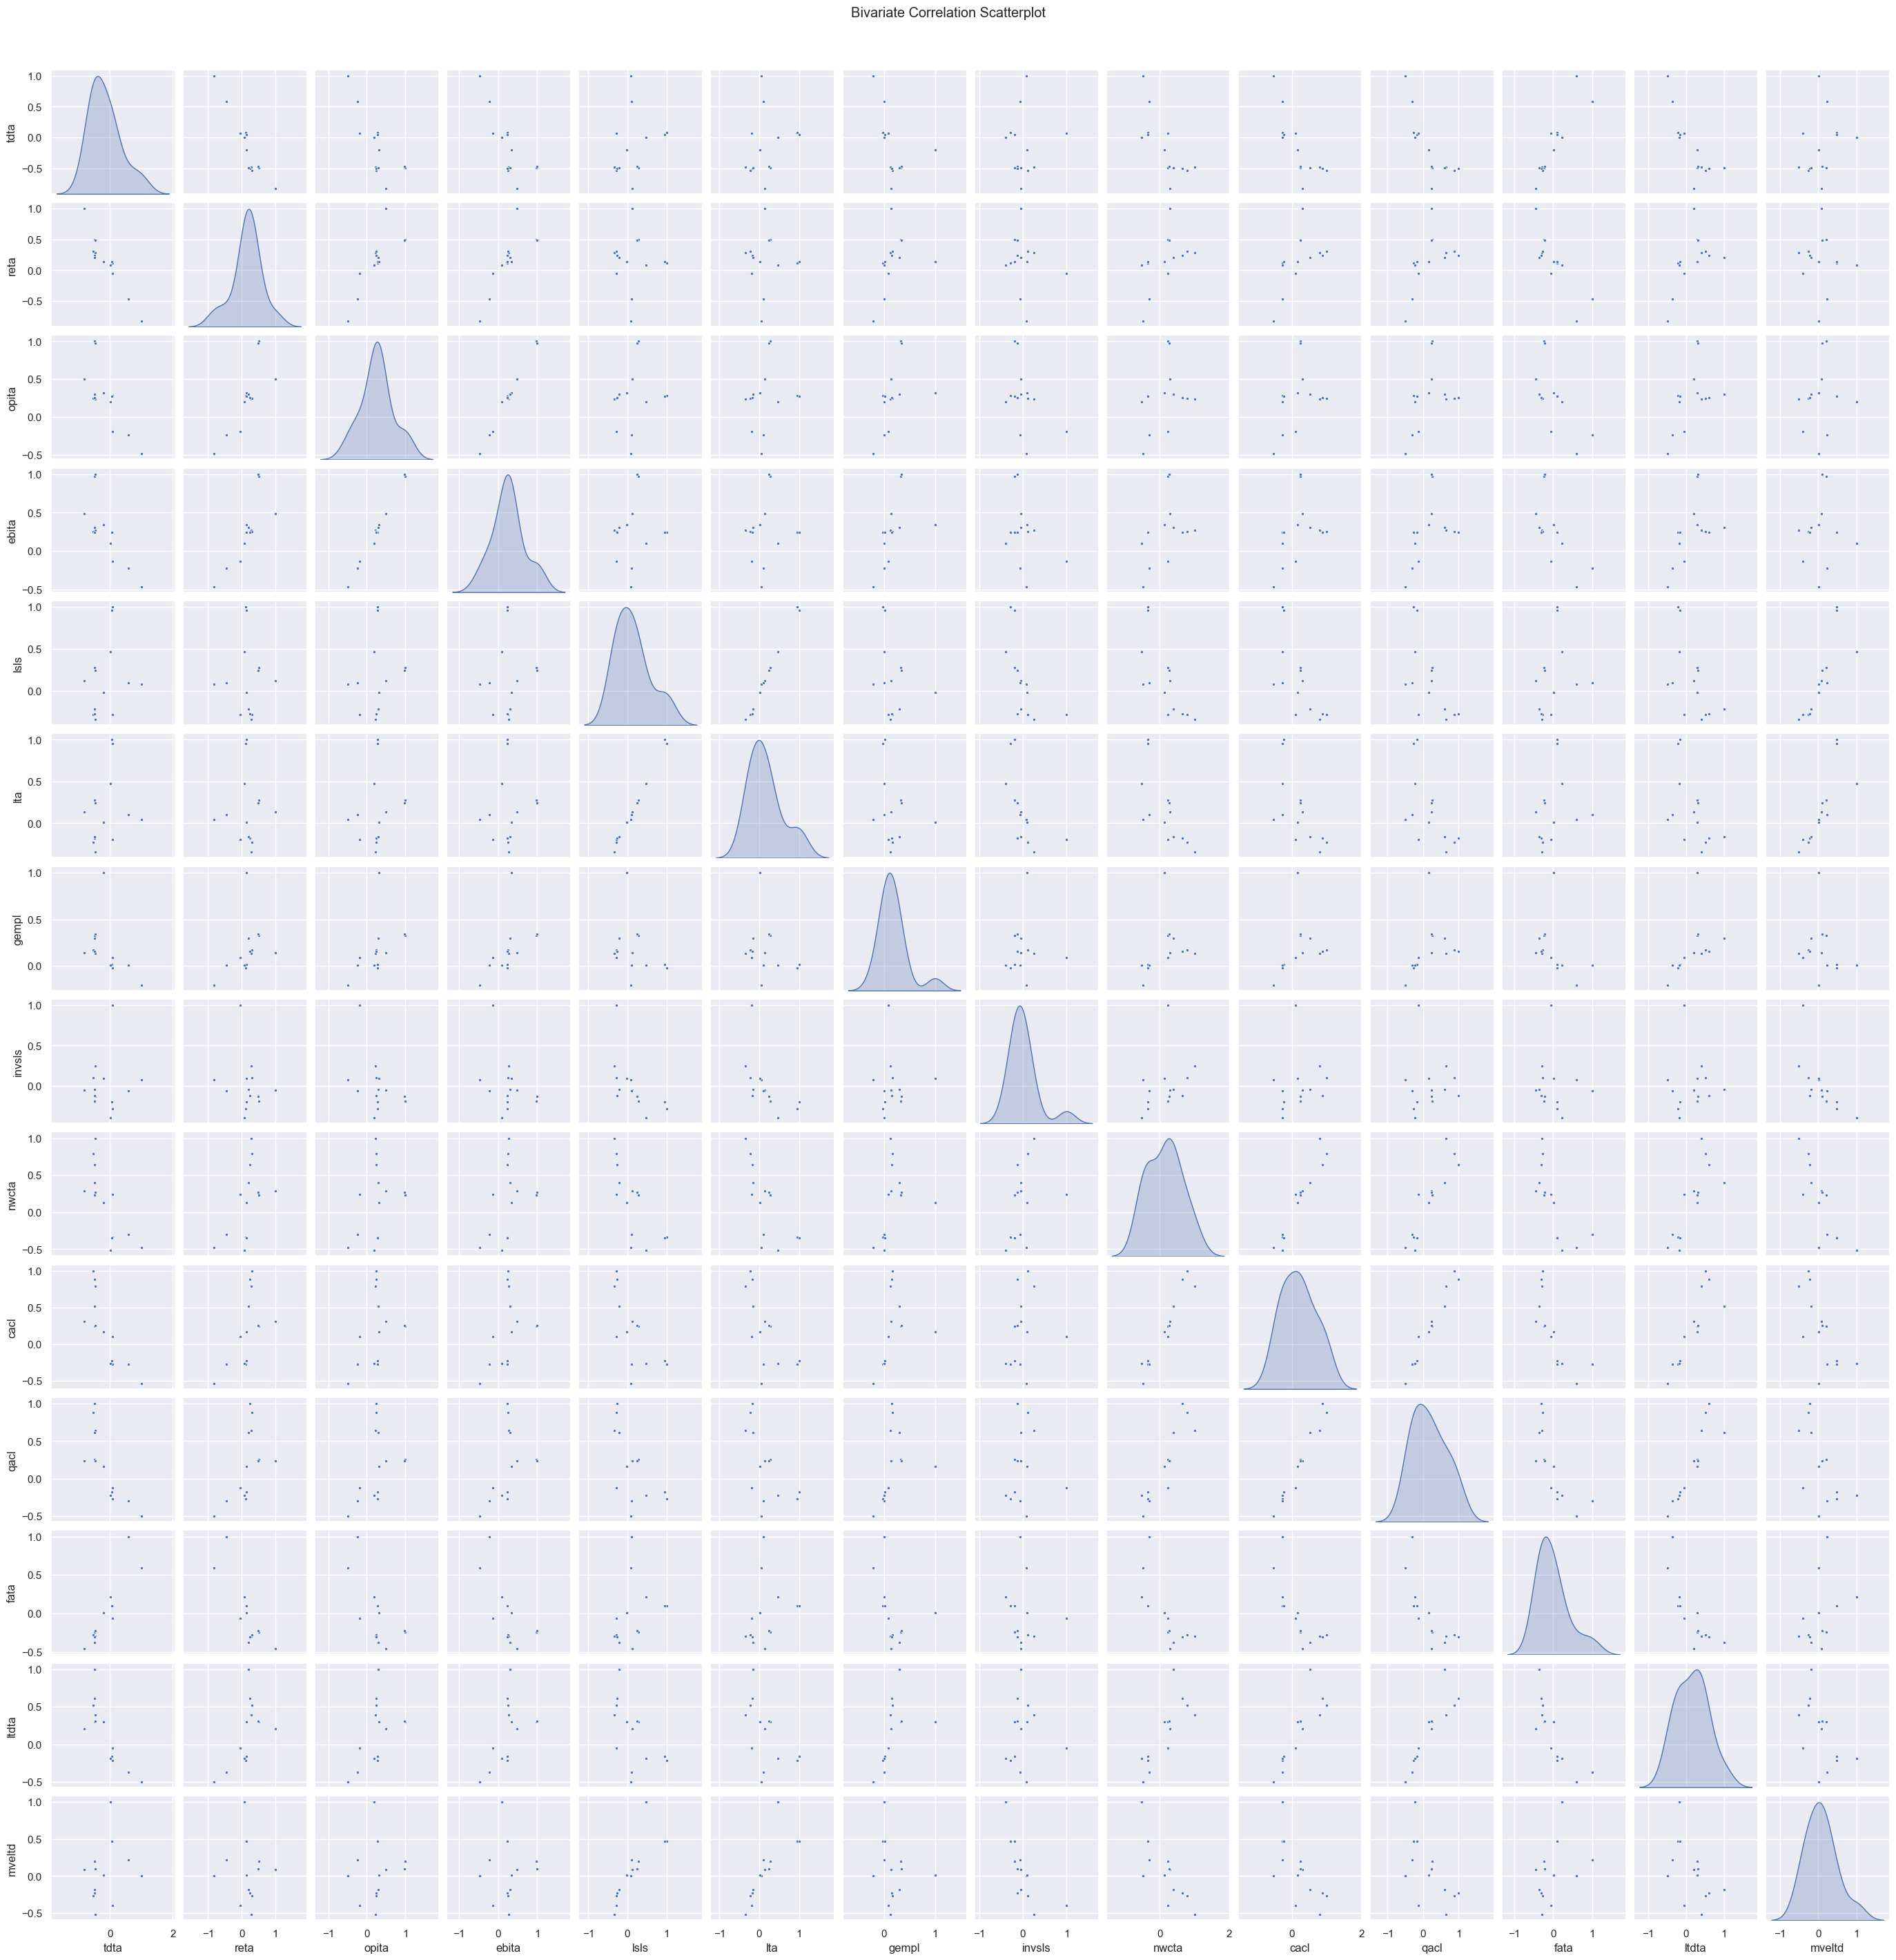

In [122]:
correlation_matrix = x.corr()
sns.set(style="darkgrid")
sns.pairplot(correlation_matrix, diag_kind="kde", markers=".", height=2)
plt.suptitle("Bivariate Correlation Scatterplot", y=1.02)
plt.show()

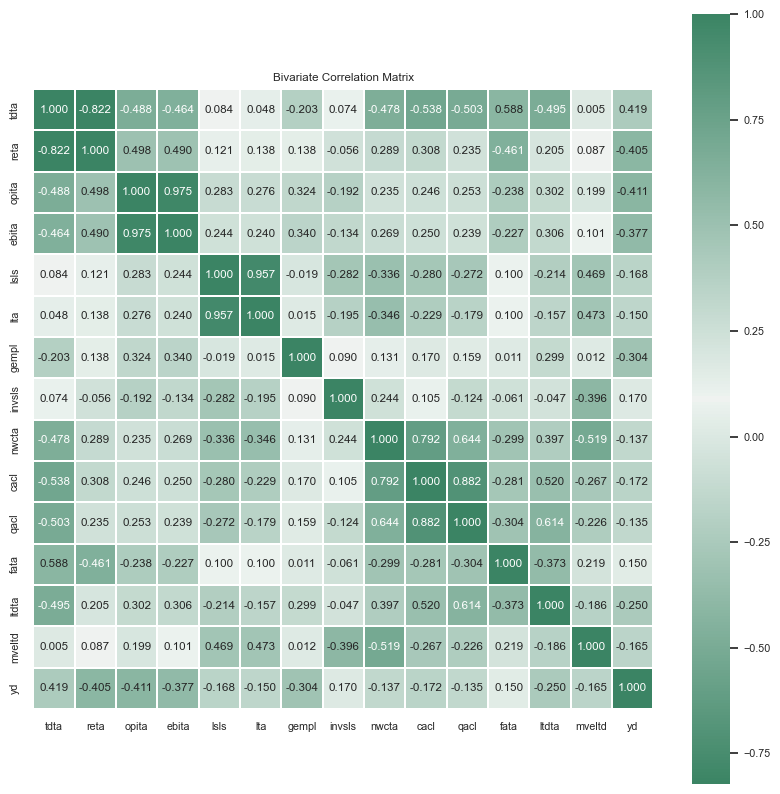

In [123]:
combined_df = pd.concat([x, y], axis=1)
correlation_matrix = combined_df.corr()

plt.figure(figsize=(10, 10))
sns.set(font_scale=0.7)

cmap = sns.diverging_palette(150, 150, as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt=".3f", linewidths=0.1, square=True)
plt.title("Bivariate Correlation Matrix")

plt.show()

The correlation matrix above gives the numerical Pearson's R correlation values for the scatterplots. Both show the bivariate correlations between all variables of the dataset. The correlation matrix is easier to read and communicates the correlations in a more accessible way, but sometimes it is useful to be able to reference the scatterplot.

##### The most correlated variables are 
reta (retained earnings) and tdta (total debt/total assets): -0.822 

This is unsurprising because earnings and debt are related. Debt is negative earnings so this is an element of retained earnings. Hence the negative correlation.

ebita (pre-tax earnings/assets) and opita (income/assets): 0.975

These ratios are almost identical so it is no wonder that they are almost perfectly correlated

lta (log assets) and lsls (log sales): 0.957 

Assets are what the business owns. We would expect a positive correlation with sales but the strength of this correlation is unusual. Perhaps this is one of the symptoms of having a dataset with relatively few observations.


qacl (quick assets/liabilities) and cacl (current assets/liabilities): 0.882 

Quick assets are highly liquid assets like cash on hand. We wouldn't expect a perfect correlation with current assets (slightly longer term assets) but a strong, positive one nevertheless.

cacl (current assets/liabilities) and wcta (net working capital/assets): 0.792

Working capital is current assets - current liabilities. We would therefore expect a correlation with current assets / liabilities because they contain a common metric.

We will not include all of these variable in our regression. Explanatory variables that are highly correlated with each other, especially those that are one and the same, will be selected to avoid collinearity. We do not want to regress on two explanatory variables that are almost identical so we will choose one or the other variable based on their correlation with the dependent variable. When the bivariate correlation is >0.8, we will make a choice and choose the variable that is more highly correlated with yd. When the correlation of a variable with the dependent is <0.1, we will exclude this variable because its explanatory power is very weak.


###### The least correlated variables are 
gempl (employment growth) and lta (log assets): 0.015 

As we mentioned earlier, employment growth was an unusual variable in this dataset. Both the mean and median gempl is negative, so it is no surprise that there are some weak correlations involving this variable.

invsls (inventory/sales) and gempl (employment growth): 0.090

fata (fixed assets/liabilities) and gempl (employment growth): 0.011




### 9. Comment the table of the bivariate clouds of points for six variables : yd, total debt and its highly correlated companion ratio, operating income / total assets and its highly correlated companion ratio, and growth of employees. Does the shape of the clouds matches with the simple correlation coefficients?

We want bivariate clouds for yd, tdta, reta, opita, ebita, gempl.

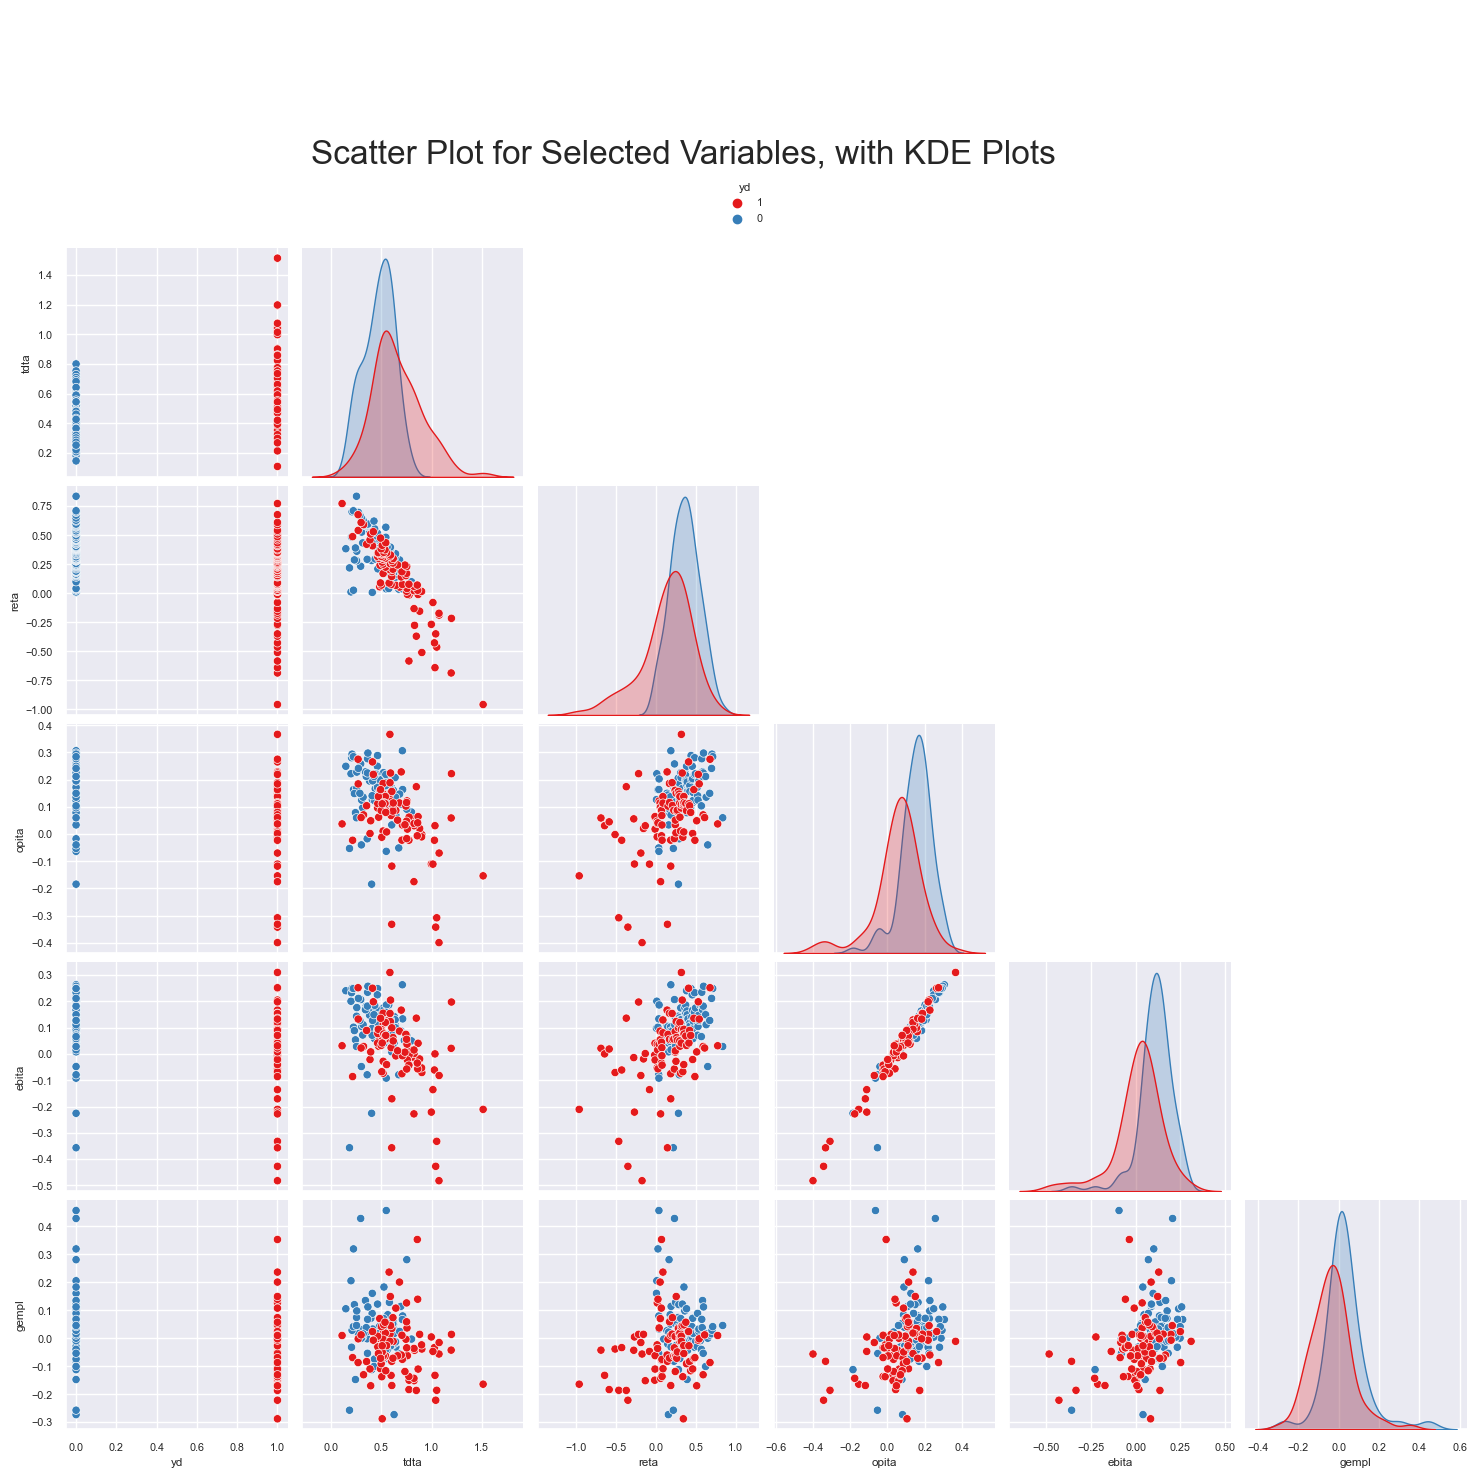

In [124]:
import warnings
with warnings.catch_warnings(record=True):
    x_vars = ['yd', 'tdta', 'reta', 'opita', 'ebita','gempl']
    g = sns.pairplot(pd.merge(x, y, left_index=True, right_index=True), 
                 hue='yd', hue_order=[1,0], vars=x_vars, kind='scatter', 
                     diag_kind='kde', palette='Set1', corner=True)
    g.fig.suptitle('Scatter Plot for Selected Variables, with KDE Plots', fontsize=24, y=0.9, x=0.45)
    g.fig.axes[0].set_visible(False)
    g.fig.legends[0].set(bbox_to_anchor=(0.5,0.85), transform=g.fig.transFigure)
    g.fig.legends[0]._ncol = 2
    
    plt.show()

What we expect: high correlations between reta and tdta; ebita and opita. We expect to see almost linear lines. Linearity implies that there is a strong correlation between the two variables, and overlay indicates that the vaues for defaulting and non-defaulting firms are similar - suggesting weak discrimination. 

We see what we expect to see. reta and tdta scatter points almost linear and have some overlap. The linearity indicates a strong correlation. The points are slightly spread and are not incredibly overlayed but they are certainly reflective of a Pearson's R of -0.822. Notice how the points are plotted sloping down to reflect the negative correlation.

Opita and ebita are almost identical (because they are almost identical financial ratios), so they form (close to) a positive gradient line.

gempl is very weakly correlated with the other variables included in this scatter plot. We noted that above and the scatter plots tell the same story. They are not more than a shapeless cloud. The same goes for ebita with tdta and ebita with reta. The correlations are very weak.

The shape of the clouds does match the correlation's presented in the matrix above.

### 10. Comment the results of the linear probability model (LPM) with only total debt/total assets are an explained variable.

We will now switch to the training data. Thus far, the analysis has been conducted using the downloaded dataset with the three observations with missing data dropped. For the estimation of the model we will use the training data in x_train and y_train and test the accuracy of the model with the test data.

The linear probability model with only tdta as an explanatory variable is a linear regression characterised by

$$ 
default_i = β_0 + β_1(\frac{total debt}{total assets})_i  + ε_i
$$


                            OLS Regression Results                            
Dep. Variable:                     yd   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     20.20
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           2.14e-05
Time:                        11:25:21   Log-Likelihood:                -55.253
No. Observations:                  89   AIC:                             114.5
Df Residuals:                      87   BIC:                             119.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -0.0689      0.132     -0.522      0.6

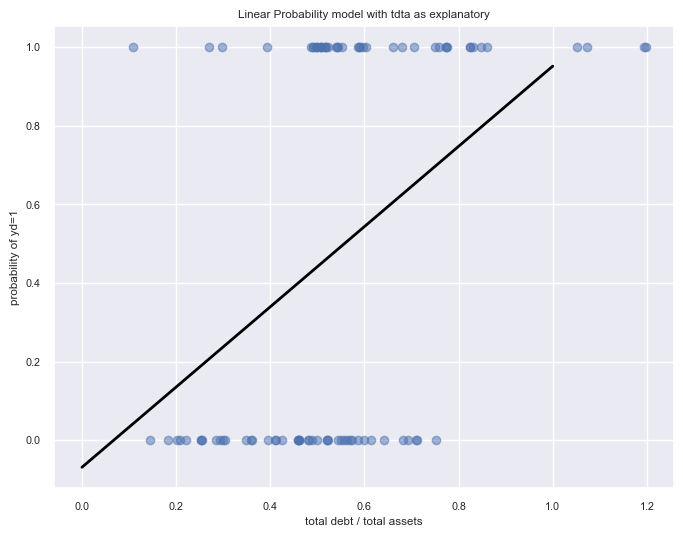

In [125]:
x_train['Constant'] = 1
x_test['Constant'] = 1
lpm_mod = sm.OLS(y_train, x_train[['Constant', 'tdta']], hasconst=True)
res = lpm_mod.fit()
print(res.summary())

intercept, slope = res.params['Constant'], res.params['tdta']

plt.figure(figsize=(8, 6))
plt.scatter(x_train['tdta'], y_train, alpha=0.5)

x_range = range(int(min(x_train['tdta'])), int(max(x_train['tdta'])) + 1)
y_predicted = intercept + slope * x_range
plt.plot(x_range, y_predicted, color='black', linewidth=2)

plt.xlabel('total debt / total assets')
plt.ylabel('probability of yd=1')
plt.title('Linear Probability model with tdta as explanatory')
plt.show()

With the linear probability model (OLS with a binary dependent variable), the probability of default is $$Pr(yd=1) = 1.0209 * \frac{total debt}{total assets} - 0.0689$$

The model is linear, so we may see the probability is not bound by 0 and 1 and the marginal effect is constant: a 0.1 unit increase in tdta increase probability of default by 0.10209.

The coefficient is positive, which we expect because total debt/total assets is positively correlated with default. And firms with excess debt are likely to be in financial distress. The coefficient is also significant with a p-value of 0.000 so we can reject the null hypothesis that $β_1 =0 $. The $R^2$ is 0.188 which is not too high but what we can expect for a model with the includion of only 1 explanatory variable.

Observation of the regression's plot shows a very poor fitting. The requirement for the probability to be linear does not fit the data well and it will be interesting to see how much better a logit or probit is.

### 11. Comment on the plot of the distribution of residuals of the linear probability model. Does it corresponds to normal law ?

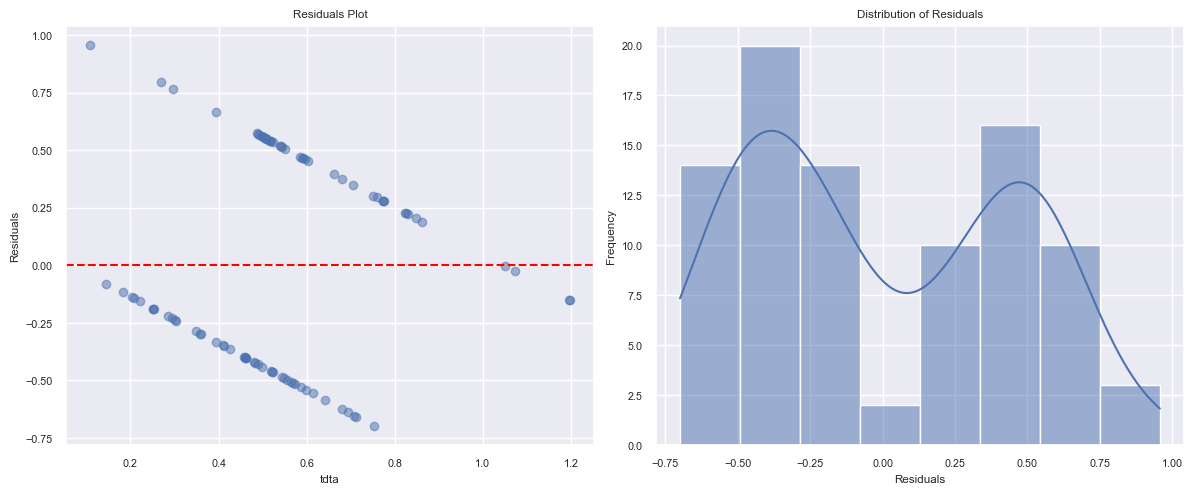

Jarque-Bera Test of Normality: 
   H0: Normal Distribution 
   Residuals P-value: 0.019
   The residuals are not normally distributed (reject the null hypothesis).


In [127]:
residuals = res.resid

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train['tdta'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('tdta')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()


print(f'Jarque-Bera Test of Normality: \n   H0: Normal Distribution \n   Residuals P-value: {stats.jarque_bera(residuals)[1]:0.3f}')
if stats.jarque_bera(residuals)[1] < 0.05:
    print("   The residuals are not normally distributed (reject the null hypothesis).")
else:
    print("   The residuals are normally distributed (fail to reject the null hypothesis).")

We absolutely do not see a normal plot of residuals. The residuals are in two spaces because they result from a binary dependent variable, 'yd', which is what gives us this bimodal distribution of residuals (twin peaks). The residuals above zero indicate a observations that were 'overpredicted'. The residuals below zero are the result of 'underpredicted' values. This is what happens when you try to estimate a binary dependent variable with a linear OLS model.


### 12. Comment the results of the logit model with only total debt/total assets as an explained variable. Comment on the plot of the distribution of residuals of the logit model. Does it fit a normal law?

Optimization terminated successfully.
         Current function value: 0.584260
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                          Logit   Df Residuals:                       87
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.1564
Time:                        10:12:49   Log-Likelihood:                -51.999
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 1.128e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -3.0041      0.837     -3.587      0.000      -4.645      -1.363
tdta           5.4766      1.

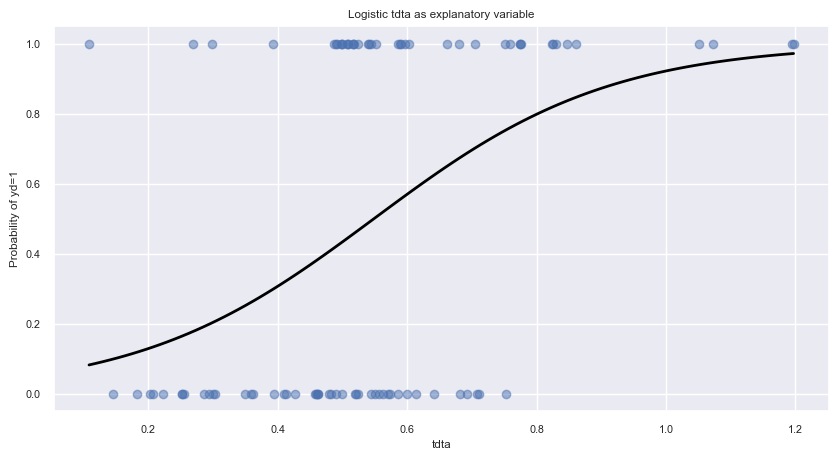

In [37]:
tdta_logit_model = sm.Logit(y_train, x_train[['Constant', 'tdta']]).fit()
print(tdta_logit_model.summary())

intercept, slope = tdta_logit_model.params['Constant'], tdta_logit_model.params['tdta']

plt.figure(figsize=(10, 5))
plt.scatter(x_train['tdta'], y_train, alpha=0.5)

x_range = np.linspace(min(x_train['tdta']), max(x_train['tdta']), 100)
logistic_curve = 1 / (1 + np.exp(-(intercept + slope * x_range)))
plt.plot(x_range, logistic_curve, color='black', linewidth=2)

plt.xlabel('tdta')
plt.ylabel('Probability of yd=1')
plt.title('Logistic tdta as explanatory variable')

plt.show()

The logistic model is of the form
$$
pr(yd=1) = σ(β_0 + β_1 * tdta_i + ε_i)
$$

where σ is the cumululative standard logit distribution function characterised by

$$
σ(x) = \frac{1}{1+e^{(-x)}}
$$

so
$$
pr(yd=1) = \frac{1}{1+e^{-(β_0 + β_1 * tdta_i + ε_i)}}
$$

Logistic regression results in a non-linear marginal effect and binds $pr(yd=1) \in (0,1)$.

The coefficent on tdta is much larger than with the linear probability model and also has a p-value of 0.000.

We can calcuate the change in probability of default when we increase total debt / total assets from 0 to 1 and compare to the linear probability model.

For the linear probability model, the increase in the probability of default when we increase tdta from 0 to 1 is
$$
Δpr = pr(yd=1|tdta=1) - pr(yd=1|tdta=0) = (1.0209 * 1 - 0.0689) - (1.0209 * 0 - 0.0689) 
$$ $$
= 1.0209
$$

And now for logit (which is a little more complicated)
$$
Δpr = pr(yd=1|tdta=1) - pr(yd=1|tdta=0) = \frac{1}{1+e^{-(-3.0041 + 5.4766 * 1)}} - \frac{1}{1+e^{-(-3.0041 + 5.4766 * 0)}}
$$ $$
= 0.8750
$$

The logit model, with probabilities constrained between 0 and 1, underpredicts the probability of default increase of a 1 unit increase in tdta relative to the linear probability model. The $pseudo R^2$ is 0.1564, slightly lower than that of the linear probability model.

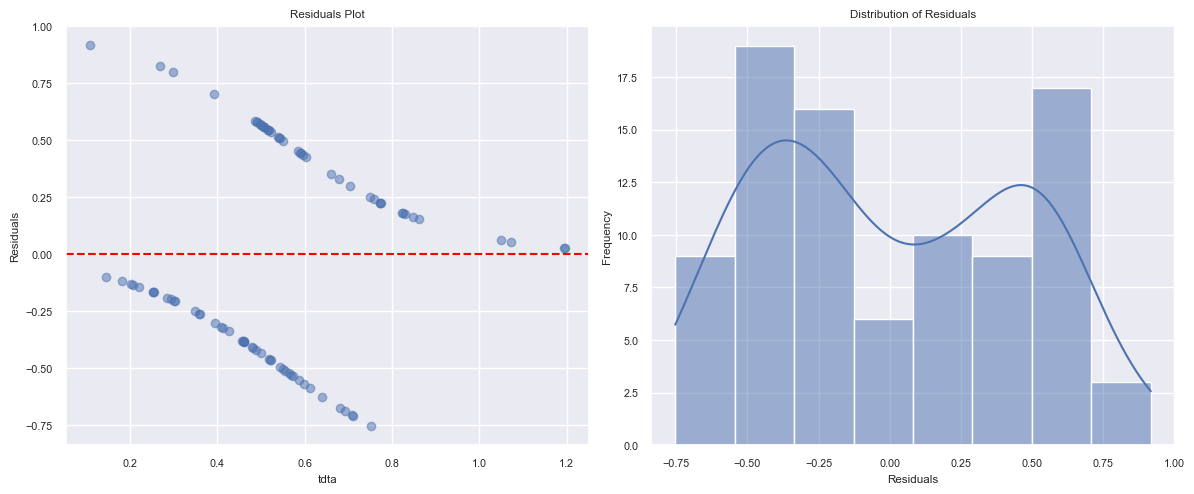

Jarque-Bera Test of Normality: 
   H0: Normal Distribution 
   Residuals P-value: 0.040
   The residuals are not normally distributed (reject the null hypothesis).


In [38]:
predicted_probs = tdta_logit_model.predict(x_train[['Constant', 'tdta']])

residuals = y_train - predicted_probs

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_train['tdta'], residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('tdta')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print(f'Jarque-Bera Test of Normality: \n   H0: Normal Distribution \n   Residuals P-value: {stats.jarque_bera(residuals)[1]:0.3f}')
if stats.jarque_bera(residuals)[1] < 0.05:
    print("   The residuals are not normally distributed (reject the null hypothesis).")
else:
    print("   The residuals are normally distributed (fail to reject the null hypothesis).")

The residuals of the logit model are not normally distributed and again have twin peaks (bimodal). The plot of the residuals is no longer linear (as was with the linear probability model) because the logit model is non-linear.

The Jarque-Bera test of normality also allows rejection of the null hypothesis that the residuals are normally distributed.

### 13. Compare the numerical values of the total debt/total assets ratio when it is the only explanatory variable for the linear probability model, the logit model and the probit model. Explain the differences ?

Optimization terminated successfully.
         Current function value: 0.584356
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                         Probit   Df Residuals:                       87
Method:                           MLE   Df Model:                            1
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.1563
Time:                        10:12:49   Log-Likelihood:                -52.008
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 1.139e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -1.7874      0.465     -3.842      0.000      -2.699      -0.876
tdta           3.2684      0.

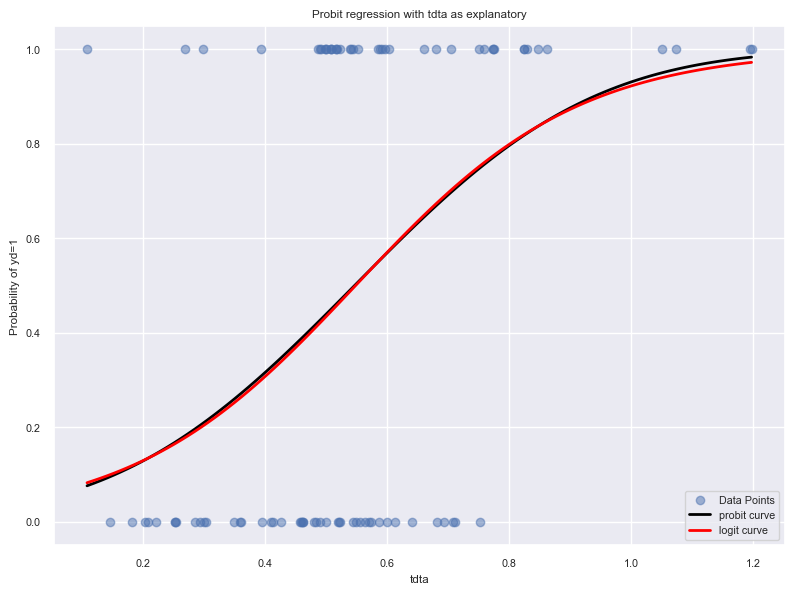

In [39]:
tdta_probit_model = sm.Probit(y_train, x_train[['Constant', 'tdta']]).fit()
print(tdta_probit_model.summary())

x_range = np.linspace(min(x_train['tdta']), max(x_train['tdta']), 100)
predicted_probs = tdta_probit_model.predict(sm.add_constant(x_range))

plt.figure(figsize=(8, 6))
plt.scatter(x_train['tdta'], y_train, label='Data Points', alpha=0.5)

plt.plot(x_range, predicted_probs, color='black', label = 'probit curve', linewidth=2)
plt.plot(x_range, logistic_curve, label = 'logit curve', color='red', linewidth=2)

plt.xlabel('tdta')
plt.ylabel('Probability of yd=1')
plt.title('Probit regression with tdta as explanatory')

plt.tight_layout()
plt.legend()
plt.show()

###### The linear model
$$
pr(yd=1)_i = -0.0689 + 1.0209 * tdta_i + ε_i 
$$

###### The Logit model
$$
pr(yd=1) = σ(-3.0041 + 5.4766 * tdta_i + ε_i)
$$

###### The Probit Model
$$
pr(yd=1) = Φ(-1.7874 + 3.2684 * tdta_i + ε_i)
$$
with 
$$\Phi(x) = \frac{1}{2} \left[ 1 + \frac{2}{\pi} \int_{0}^{\frac{x - \mu}{\sigma\sqrt{2}}} e^{-s^2} ds \right]$$

The logit model has the largest (in absolute value) intercept and the largest coefficient on tdta. The logit and probit plots are almost identical, especially around the median so it is difficult to distinguish the different levels of predictability and the $pseudo R^2$s are almost identical.

The coefficients of total debt/total assets for the three models is not directly comparable because the linear model is simply linear while the logit and probit models use distribution functions. That is why, even with the different parameter values in the regression output tables, the logit and probit models perform very similarly.

Recall that the change in probability by increasing total debt/total assets from 0 to 1 for the linear probability model is
$$
Δpr = pr(yd=1|tdta=1) - pr(yd=1|tdta=0) = (1.0209 * 1 - 0.0689) - (1.0209 * 0 - 0.0689) 
$$ $$
= 1.0209
$$

and for logit it was
$$
Δpr = pr(yd=1|tdta=1) - pr(yd=1|tdta=0) = \frac{1}{1+e^{-(-3.0041 + 5.4766 * 1)}} - \frac{1}{1+e^{-(-3.0041 + 5.4766 * 0)}}
$$ $$
= 0.8750
$$

Let us do the same for probit using Z tables
$$
Δpr = pr(yd=1|tdta=1) - pr(yd=1|tdta=0) = Φ(-1.7874 + 3.2684 * 1) - Φ(-1.7874 + 3.2684 * 0) = 0.9306 - 0.0367 = 0.8938
$$

The marginal effect of tdta increasing from 0 to 1 is greatest for the linear probability model (exceeding 1), with probit and logit being very similar at around 0.9.

## Model predictions

### 14. Explain how you obtain the percentage of concordant pairs when the dependent variable is binary.

A concordant pair is a pair of observations, $x_0$ and $y_0$ from the yd=0 subset, and $x_1$ and $y_1$ from the yd=1 subset. We compare every observation of $x_0$ against every observation of $x_1$ and we have a concordant pair if $sgn(x_1 - x_0) = sgn(y_1 - y_0)$. This means that, given tdta is positively related with default, a concordant pair would be two observations where if tdta is larger for one, then the probability of default will also be higher. In other words, they are concordant when the ordering is the 'right way around' for both the predictor variable and the dependent variable.

This is no difficulty with using a binary dependent variable because we can assess based on probabilities. So we have a concordant pair if $y_1 > y_0$ while at the same time $pr(yd = 1)_1 > pr(yd = 1)_0$. This means the variables are 'ordered correctly' for use of another term. We predict the probability of default, and if the probability of firm 1's default is higher than firm 0's then this is a concordant pair if firm 1 defaulted and firm 0 didn't. They are discordant if one of the '>'s is the other way around (so comparison of two firms, one of which has a higher tdta, does not also have a higher probability of default. We are looking at comparisons between two groups: defaulted and non-defaulted so we compare every non-defaulted firm against every defaulted firm, always looking for a higher probability of default in the defaulted firm group - this makes a concordant pair.

In [40]:
from itertools import product
concordant = 0
discordant = 0
x_tie = 0
y_tie = 0
tied_pairs = []
default_group = y_train[y_train == 1]
nondefault_group = y_train[y_train == 0]

In [41]:
pairs = list(product(default_group.index, nondefault_group.index))
for pair in pairs:
    y_true1, y_true2 = y_train.loc[pair[0]], y_train.loc[pair[1]]
    y_hat1, y_hat2 = tdta_probit_model.predict(x_train.loc[pair[0], ['Constant', 'tdta']].values), tdta_probit_model.predict(x_train.loc[pair[1], ['Constant', 'tdta']].values)
    
    if ((y_true1 > y_true2) & (y_hat1 > y_hat2)) | ((y_true1 < y_true2) & (y_hat1 < y_hat2)):
        concordant += 1
    elif ((y_true1 > y_true2) & (y_hat1 < y_hat2)) | ((y_true1 < y_true2) & (y_hat1 > y_hat2)):
        discordant += 1
    elif (y_true1 == y_true2) & (y_hat1 != y_hat2):
        y_tie += 1
    elif (y_true1 != y_true2) & (y_hat1 == y_hat2):
        x_tie += 1    

In [42]:
print(f'Concordant pairs: {concordant} out of {len(pairs)} = {concordant / len(pairs) * 100 :0.4f}%')
print(f'Discordant pairs: {discordant} out of {len(pairs)} = {discordant / len(pairs) * 100 :0.4f}%')

Concordant pairs: 1478 out of 1978 = 74.7219%
Discordant pairs: 500 out of 1978 = 25.2781%


For our probit model, 75% are concordant which is a promising indication of the effectiveness of our model. Concordant pairs can be an indication of type 1 and type 2 errors. Type 1 errors occur when we give a false positive (will default when it doesn't) and type 2 is a false negative (won't default when it does). The percentage of concordant pairs shows the percentage of predictions that are correct: we predict a default and we get one, or we predict a healthy firm and we get one. Discordant pairs can have type 1 and type 2 errors: we predict healthy but it defaults, or we predict default but its healthy.

We will see in the next section the link between the ROC curve and concordant pairs.

### 15. What is the value of the AUC, area under the ROC curve when you used only total debt/total assets as an explanatory variable ? Is there a link of the AUC with the number of concordant pairs (define what is a concordant pair) ?

In [43]:
from matplotlib import cm
from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
lpm_mod = sm.OLS(y_train, x_train[['Constant', 'tdta']], hasconst=True).fit()
tdta_logit_model = sm.Logit(y_train, x_train[['Constant', 'tdta']]).fit()
tdta_probit_model = sm.Probit(y_train, x_train[['Constant', 'tdta']]).fit()

Optimization terminated successfully.
         Current function value: 0.584260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584356
         Iterations 6


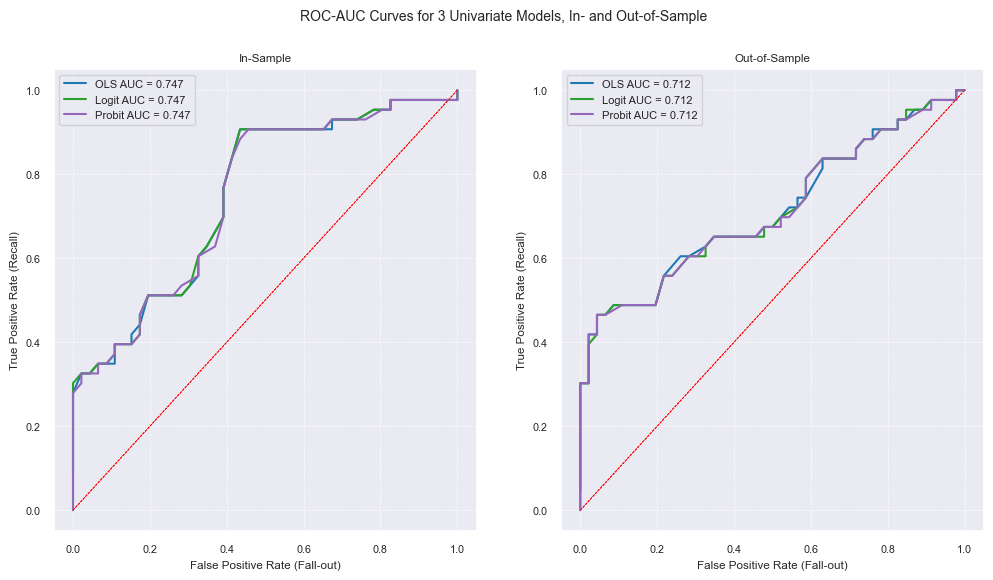

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)
x_vars = ['Constant', 'tdta']
models = [lpm_mod, tdta_logit_model, tdta_probit_model]
model_names = ['OLS', 'Logit', 'Probit']

for model, name, color in zip(models, model_names, cm.tab10([0, .2, .4])):
    for x_frame, y_frame, axis in zip([x_train, x_test], [y_train, y_test], fig.axes):
        tpr = []
        fpr = []
        for threshold in np.linspace(0, 1, 100):
            if name == 'OLS':
                predicted_probabilities = model.predict(x_frame[x_vars])
            else:
                predicted_probabilities = model.predict(sm.add_constant(x_frame[x_vars]))

            if len(y_frame) != len(predicted_probabilities):
                raise ValueError("Number of samples in y_frame and predictions do not match.")

            y_hat = [1 if x > threshold else 0 for x in predicted_probabilities]

            TP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            FP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))
            FN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            TN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))

            tpr.append(TP / (TP + FN))
            fpr.append(FP / (FP + TN))

        score = roc_auc_score(y_frame, predicted_probabilities)

        axis.plot(fpr, tpr, label=f'{name} AUC = {score:.3f}', color=color, alpha=1)
        axis.plot([0, 1], [0, 1], ls='--', lw=0.5, color='red')
        axis.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
        axis.grid(ls='--', lw=0.5)
        axis.set_ylabel('True Positive Rate (Recall)')
        axis.set_xlabel('False Positive Rate (Fall-out)')
        if (x_frame.values == x_train.values).all():
            axis.set_title('In-Sample')
        else:
            axis.set_title('Out-of-Sample')
        axis.legend(loc='best', fontsize=8)

fig.suptitle('ROC-AUC Curves for 3 Univariate Models, In- and Out-of-Sample')
plt.show()


In [46]:
models = [lpm_mod, tdta_logit_model, tdta_probit_model]
model_names = ['LPM', 'Logit', 'Probit']

for model, name in zip(models, model_names):
    print(f'Concordant pairs: {concordant / len(pairs)}')
    auc = roc_auc_score(y_train, model.predict(x_train[x_vars]))
    print(f'AUC for {name}: {auc}')
    difference = (concordant / len(pairs)) - auc
    print(f'Difference for {name}: {difference}')
    print('='*40)


Concordant pairs: 0.7472194135490394
AUC for LPM: 0.7472194135490395
Difference for LPM: -1.1102230246251565e-16
Concordant pairs: 0.7472194135490394
AUC for Logit: 0.7472194135490395
Difference for Logit: -1.1102230246251565e-16
Concordant pairs: 0.7472194135490394
AUC for Probit: 0.7472194135490395
Difference for Probit: -1.1102230246251565e-16


The 'Receiver Operating Characteristic' (ROC curve) illustrates the effectiveness of our prediction models, plotting true positive against false positive. The more concave our curve is, the better classifier it is. Any model that has an ROC curve on the 45% line is worthless, and classifies the same number of false positives as it does true positives - it is as good as flipping a coin.

Therefore, we wish for a model to maximise the area under the curve (AUC). The higher the AUC, the better classifier it is. Naturally, the AUC and the proportion of concordant pairs is the same. This makes sense, because the dimensions of the ROC are (1.0, 1.0), so the area under the curve can act as a proportion of correctly classified observations (i.e. the concordant pair proportion). It makes a lot of sense that they are the same and indeed the number of concordant pairs and the AUC are calculated in the same way. Concordant pairs are, by definition, the correctly 'classified' observations that obey the positive correlation of yd to tdta.

### 16. Include your preferred list of explanatory variables out of the 14 financial ratios. Estimate the model with logit. Comment the results. Comment the value of the area under the ROC curve.


The correlation with the dependent variable, yd, is how we will select our explanatory variables.

The most correlated variable with yd is total debt / total assets (0.41914***). The variables other than tdta which are the most strongly correlated with default are negatively correlated: income/assets (-0.411487***), retained earnings (-0.405487***), pre-tax earnings/assets (-0.377183***) and growth in employment (-0.304482***).

Before we confirm these explanatory variables, we want to make sure they are not too strongly correlated with each other. So we will return to question 8 and look at the bivariate correlations.

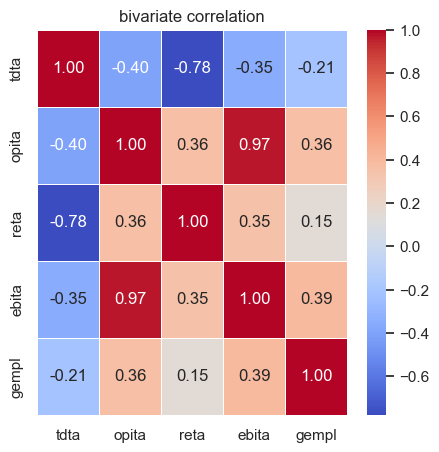

In [47]:
selected_columns = ['tdta', 'opita', 'reta', 'ebita', 'gempl']
selected_data = x_train[selected_columns]
correlation_matrix = selected_data.corr()
plt.figure(figsize=(5, 5))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('bivariate correlation')
plt.show()


Opita and ebita are far too strongly correlated. This is because the ratios are almost identical, so we will eliminate ebita because it is less strongly correlated with yd compared to opita. The only other concern is tdta (total debt/total assets) and reta (retained earnings/assets). This is because of the relation between earnings and debt (debt is negative earnings). We will exclude retained earnings/assets to avoid collinearity. Gempl is less strongly correlated with yd, but has very little correlation to the other explanatory variables.

So the final selection of explanatory variables is: tdta (total debt/total assets), opita (income/assets), gempl (growth in employment).

In [48]:
all_var = ['Constant', 'tdta', 'reta', 'opita', 'ebita', 'lsls', 'lta', 'gempl', 'invsls', 'nwcta', 'cacl', 'qacl', 'fata', 'ltdta', 'mveltd'] 
full_logit_model = sm.Logit(y_train, x_train[all_var]).fit()
print(full_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.370035
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                          Logit   Df Residuals:                       74
Method:                           MLE   Df Model:                           14
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.4657
Time:                        10:12:51   Log-Likelihood:                -32.933
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 3.317e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       1.3502      3.642      0.371      0.711      -5.789       8.489
tdta           5.7659      6.

In [49]:
partial_logit_model = sm.Logit(y_train, x_train[['Constant', 'tdta', 'opita', 'gempl']]).fit()
print(partial_logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.464801
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                          Logit   Df Residuals:                       85
Method:                           MLE   Df Model:                            3
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.3289
Time:                        10:12:51   Log-Likelihood:                -41.367
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 8.168e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -1.8202      1.137     -1.600      0.110      -4.049       0.409
tdta           5.5148      1.

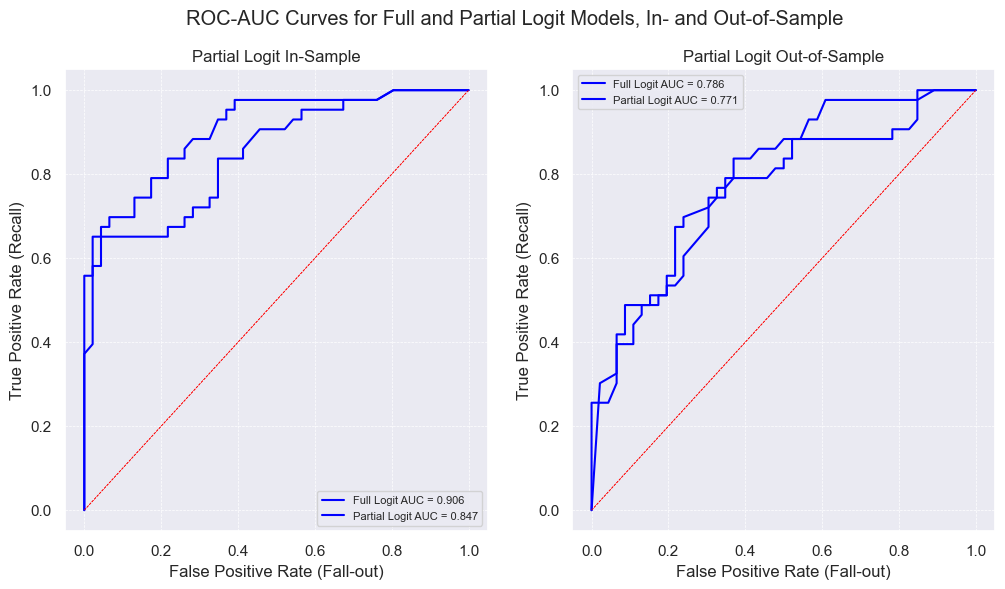

In [50]:
all_var = ['Constant', 'tdta', 'reta', 'opita', 'ebita', 'lsls', 'lta', 'gempl', 'invsls', 'nwcta', 'cacl', 'qacl', 'fata', 'ltdta', 'mveltd']
partial_var = ['Constant', 'tdta', 'opita', 'gempl']

models = [full_logit_model, partial_logit_model]
model_names = ['Full Logit', 'Partial Logit']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

for model, name, var in zip(models, model_names, [all_var, partial_var]):
    for x_frame, y_frame, axis in zip([x_train, x_test], [y_train, y_test], fig.axes):
        predicted_probabilities = model.predict(x_frame[var])

        tpr = []
        fpr = []
        for threshold in np.linspace(0, 1, 100):
            y_hat = [1 if x > threshold else 0 for x in predicted_probabilities]

            TP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            FP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))
            FN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            TN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))

            tpr.append(TP / (TP + FN))
            fpr.append(FP / (FP + TN))

        score = roc_auc_score(y_frame, predicted_probabilities)
        axis.plot(fpr, tpr, label=f'{name} AUC = {score:.3f}', color='blue', alpha=1)
        axis.plot([0, 1], [0, 1], ls='--', lw=0.5, color='red')
        axis.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
        axis.grid(ls='--', lw=0.5)
        axis.set_ylabel('True Positive Rate (Recall)')
        axis.set_xlabel('False Positive Rate (Fall-out)')
        if (x_frame.values == x_train.values).all():
            axis.set_title(f'{name} In-Sample')
        else:
            axis.set_title(f'{name} Out-of-Sample')
        axis.legend(loc='best', fontsize=8)
fig.suptitle('ROC-AUC Curves for Full and Partial Logit Models, In- and Out-of-Sample')
plt.show()

Recall the univariate models
###### The linear model
$$
pr(yd=1)_i = -0.0689 + 1.0209 * tdta_i + ε_i 
$$

###### The Logit model
$$
pr(yd=1) = σ(-3.0041 + 5.4766 * tdta_i + ε_i)
$$

###### The Probit Model
$$
pr(yd=1) = Φ(-1.7874 + 3.2684 * tdta_i + ε_i)
$$

Let us also estimate the model for all explanatory variables for comparison. The full logit models area under curve is 0.906 in sample but this declines to 0.786 out of sample, reflective of the overfitting. The partial logit model has a pseudo $R^2$ of 0.3289, an AUC of 0.847, slightly lower than the full model in-sample, and this declines to 0.771 out of sample. There is evidently less overfitting, but it does seem as though we could do a little better by including some more explanatory variables as the full model still performs better.

Let's go ahead and include the next highly correlated variables ltdta (-0.250152***), calc (-0.172408**) and lsls (-29.9887**). We will check the bivariate correlations first.

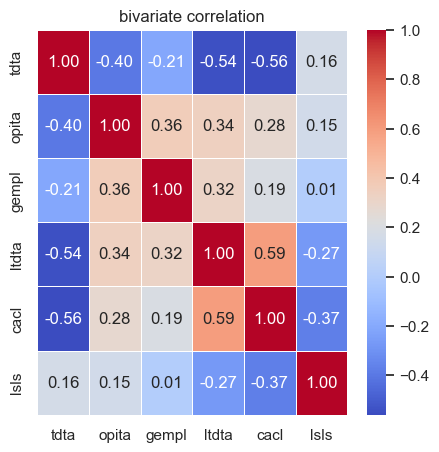

In [51]:
selected_columns = ['tdta', 'opita', 'gempl', 'ltdta', 'cacl', 'lsls']
selected_data = x_train[selected_columns]
correlation_matrix = selected_data.corr()
plt.figure(figsize=(5, 5))
sns.set(font_scale=1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('bivariate correlation')
plt.show()

There are no bivariate correlations that are too alarming so we will use the explanatory variables:

tdta: total Debt/Assets

opita: Income/Assets

gempl: Employment Growth

ltdta: Long-Term Debt/Total Assets

cacl: Current Assets/Liabilities

lsls: Log Sales

We shall redefine this as our partial_logit_model2.

In [52]:
partial_logit_model2 = sm.Logit(y_train, x_train[['Constant', 'tdta', 'opita', 'gempl', 'ltdta', 'cacl', 'lsls']]).fit()
print(partial_logit_model2.summary())

Optimization terminated successfully.
         Current function value: 0.429093
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                          Logit   Df Residuals:                       82
Method:                           MLE   Df Model:                            6
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.3804
Time:                        10:12:51   Log-Likelihood:                -38.189
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 1.959e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -1.7327      2.290     -0.757      0.449      -6.220       2.755
tdta           7.8437      2.

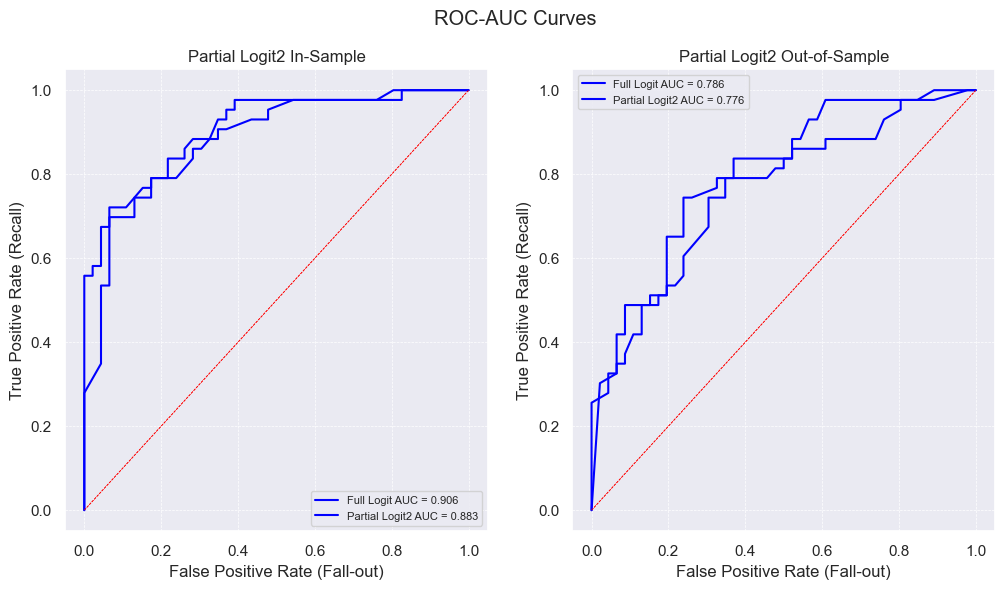

In [53]:
all_var = ['Constant', 'tdta', 'reta', 'opita', 'ebita', 'lsls', 'lta', 'gempl', 'invsls', 'nwcta', 'cacl', 'qacl', 'fata', 'ltdta', 'mveltd']
partial_var2 = ['Constant', 'tdta', 'opita', 'gempl', 'ltdta', 'cacl', 'lsls']

models = [full_logit_model, partial_logit_model2]
model_names = ['Full Logit', 'Partial Logit2']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

for model, name, var in zip(models, model_names, [all_var, partial_var2]):
    for x_frame, y_frame, axis in zip([x_train, x_test], [y_train, y_test], fig.axes):
        predicted_probabilities = model.predict(x_frame[var])

        tpr = []
        fpr = []
        for threshold in np.linspace(0, 1, 100):
            y_hat = [1 if x > threshold else 0 for x in predicted_probabilities]

            TP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            FP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))
            FN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            TN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))

            tpr.append(TP / (TP + FN))
            fpr.append(FP / (FP + TN))

        score = roc_auc_score(y_frame, predicted_probabilities)
        axis.plot(fpr, tpr, label=f'{name} AUC = {score:.3f}', color='blue', alpha=1)
        axis.plot([0, 1], [0, 1], ls='--', lw=0.5, color='red')
        axis.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
        axis.grid(ls='--', lw=0.5)
        axis.set_ylabel('True Positive Rate (Recall)')
        axis.set_xlabel('False Positive Rate (Fall-out)')
        if (x_frame.values == x_train.values).all():
            axis.set_title(f'{name} In-Sample')
        else:
            axis.set_title(f'{name} Out-of-Sample')
        axis.legend(loc='best', fontsize=8)
fig.suptitle('ROC-AUC Curves')
plt.show()

We do see an improvement in the AUC but we are still not as successful as we are with the inclusion of all explanatory variables. Our pseudo $R^2$ does decline from the original partial model and we fail to reject the null hypothesis of the coefficient of ltdta being equal to zero. Overall, I don't think that a model trained with 89 observations having an AUC of 0.776 out of sample is bad.

### 17. Compute studentized residuals of your model. Do you find outliers ?

A studentized residual is the quotient resulting from the division of a residual by an estimate of its standard deviation and is important in the detection of outliers. The code below calculates the studentised residuals for the train dataframe.

In [54]:
predicted_probabilities_log2 = partial_logit_model2.predict(x_train[partial_var2])
residuals = y_train - predicted_probabilities_log2
standard_errors = np.sqrt(predicted_probabilities_log2 * (1 - predicted_probabilities_log2))
studentized_residuals = residuals / standard_errors

In [55]:
studentized_residuals.head()

0    -0.477524
2    -0.147962
4    -1.052588
6    -1.134587
10   -2.983988
dtype: float64

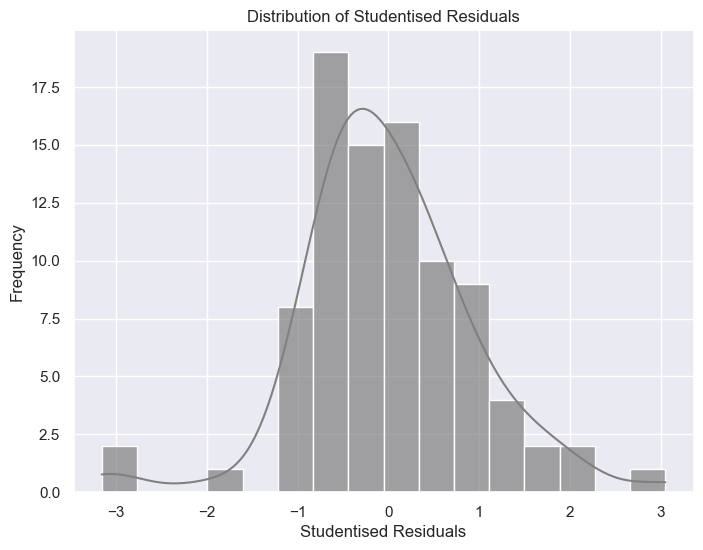

Jarque-Bera Test of Normality: 
   H0: Normal Distribution 
   Residuals P-value: 0.000
   The residuals are not normally distributed (reject the null hypothesis).


In [56]:
plt.figure(figsize=(8, 6))
sns.histplot(studentized_residuals, kde=True, color='grey', alpha=0.7)
plt.title('Distribution of Studentised Residuals')
plt.xlabel('Studentised Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f'Jarque-Bera Test of Normality: \n   H0: Normal Distribution \n   Residuals P-value: {stats.jarque_bera(studentized_residuals)[1]:0.3f}')
if stats.jarque_bera(studentized_residuals)[1] < 0.05:
    print("   The residuals are not normally distributed (reject the null hypothesis).")
else:
    print("   The residuals are normally distributed (fail to reject the null hypothesis).")

In [57]:
threshold = 3

filtered_data = x_train[abs(studentized_residuals) <= threshold]
filtered_target = y_train[abs(studentized_residuals) <= threshold]

partial_logit_model2_filtered = sm.Logit(filtered_target, filtered_data[partial_var2]).fit()

print(partial_logit_model2_filtered.summary())


Optimization terminated successfully.
         Current function value: 0.375661
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   87
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                            6
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.4576
Time:                        10:12:52   Log-Likelihood:                -32.683
converged:                       True   LL-Null:                       -60.252
Covariance Type:            nonrobust   LLR p-value:                 4.345e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -2.6300      2.761     -0.952      0.341      -8.042       2.782
tdta           9.5477      3.

Having excluded outliers using the rule of thumb 'studentised residuals > 3' in abolsute value, the performance of our model actually declines out of sample. We have a much better in-sample predictive power, which is to be expected given that we have removed outliers with studentised residuals > 3 in absolute value. The in-sample AUC is 0.908, but out of sample we still cannot fit the data with an AUC greater than 0.771.

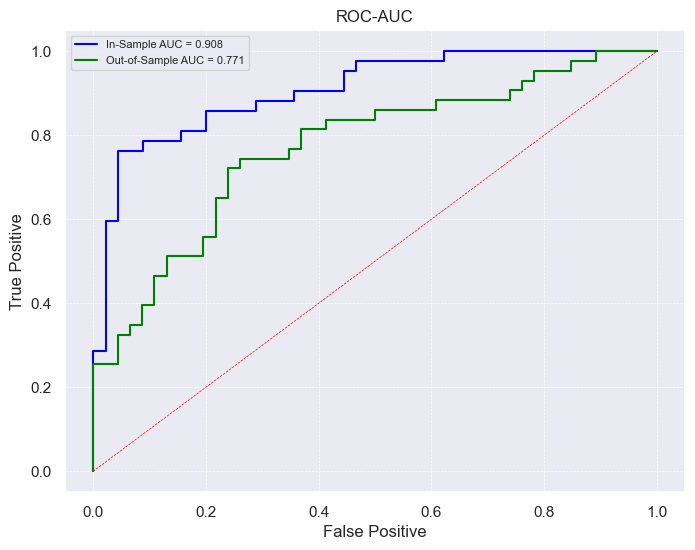

In-Sample AUC: 0.908
Out-of-Sample AUC: 0.771


In [58]:
filtered_in_sample_data = x_train[abs(studentized_residuals) <= threshold]
filtered_in_sample_target = y_train[abs(studentized_residuals) <= threshold]

predicted_probabilities_in_sample = partial_logit_model2_filtered.predict(filtered_in_sample_data[partial_var2])

fpr_in_sample, tpr_in_sample, _ = roc_curve(filtered_in_sample_target, predicted_probabilities_in_sample)
auc_in_sample = roc_auc_score(filtered_in_sample_target, predicted_probabilities_in_sample)

predicted_probabilities_out_sample = partial_logit_model2_filtered.predict(x_test[partial_var2])

fpr_out_sample, tpr_out_sample, _ = roc_curve(y_test, predicted_probabilities_out_sample)
auc_out_sample = roc_auc_score(y_test, predicted_probabilities_out_sample)

plt.figure(figsize=(8, 6))
plt.plot(fpr_in_sample, tpr_in_sample, label=f'In-Sample AUC = {auc_in_sample:.3f}', color='blue')
plt.plot(fpr_out_sample, tpr_out_sample, label=f'Out-of-Sample AUC = {auc_out_sample:.3f}', color='green')
plt.plot([0, 1], [0, 1], ls='--', lw=0.5, color='red')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(ls='--', lw=0.5)
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.title('ROC-AUC')
plt.legend(loc='best', fontsize=8)
plt.show()

print(f'In-Sample AUC: {auc_in_sample:.3f}')
print(f'Out-of-Sample AUC: {auc_out_sample:.3f}')


I am still not entirely impressed with the model. For this reason, we will use Principal Component Analysis for the explanatory variable choice. We can use PCA to keep variables of greater significance and discard those of lesser significance. The PCA method standardises the variables, computes the covariance matrix and eigenvalues to keep the variables with variance in order to maximise the variance between defaulting firms and healthy firms.

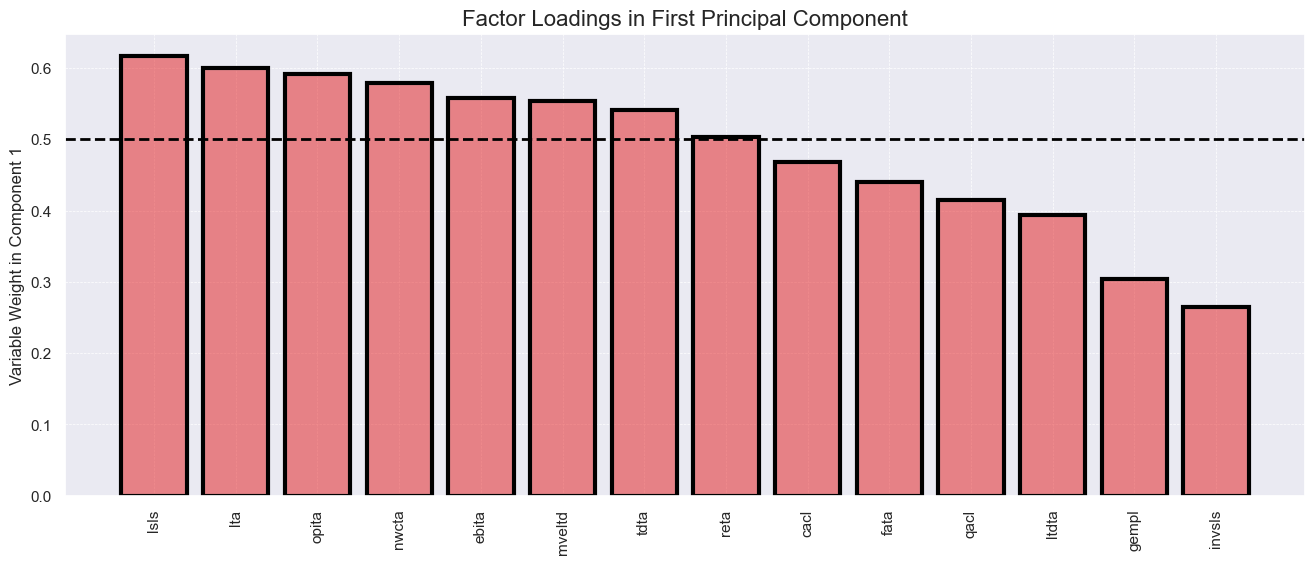

In [59]:
x_vars1 = x_train.corrwith(y_train).apply(np.abs).sort_values(ascending=False).index.tolist()
x_vars1.insert(0, 'Constant')
x_vars1 = x_vars1[:-1]
fig, ax = plt.subplots(figsize=(16,6))
centered = (x_train[x_vars1[1:]] - x_train[x_vars1[1:]].mean())/x_train[x_vars1[1:]].std()
w, v = np.linalg.eig(centered.cov())
comp_1 = np.apply_along_axis(np.sum, 1, np.abs(v[:, :2]))
names = centered.columns[comp_1.argsort()[::-1]].tolist()
ax.grid(ls='--', lw=0.5, zorder=1)
ax.bar(names, comp_1[comp_1.argsort()][::-1].tolist(), lw=3, zorder=1, facecolor=cm.Set1_r(8), alpha=0.5)
ax.bar(names, comp_1[comp_1.argsort()][::-1].tolist(), lw=3, zorder=2, facecolor='none', edgecolor='black')
ax.axhline(0.5, ls='--', color='black', lw=2)
#jesse_tools.remove_chart_ink(ax)
ax.tick_params(axis='x',
              rotation=90)
ax.set_title('Factor Loadings in First Principal Component', fontsize=16)
ax.set_ylabel('Variable Weight in Component 1')
plt.show()

Going for the middle of the road threshold of 0.5, we select lsls (log sales), lta (log assets), opita (income/assets), nwcta (net working capital / assets), (ebita we will not include because of collinearity) mveltd (market value equity/long-term debt), tdta (total debt/assets) and reta (retained earnings/assets).

We are including far more variables than the other logit models we have estimated so we expect a higher AUC for in-sample. However, it will be interesting to see how the model performs out-of-sample (test).


In [60]:
pca_logit_model = sm.Logit(y_train, x_train[['Constant', 'lsls', 'lta', 'opita', 'nwcta', 'mveltd', 'tdta', 'reta']]).fit()
print(partial_logit_model2.summary())

Optimization terminated successfully.
         Current function value: 0.474394
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     yd   No. Observations:                   89
Model:                          Logit   Df Residuals:                       82
Method:                           MLE   Df Model:                            6
Date:                Mon, 09 Oct 2023   Pseudo R-squ.:                  0.3804
Time:                        10:12:52   Log-Likelihood:                -38.189
converged:                       True   LL-Null:                       -61.640
Covariance Type:            nonrobust   LLR p-value:                 1.959e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -1.7327      2.290     -0.757      0.449      -6.220       2.755
tdta           7.8437      2.

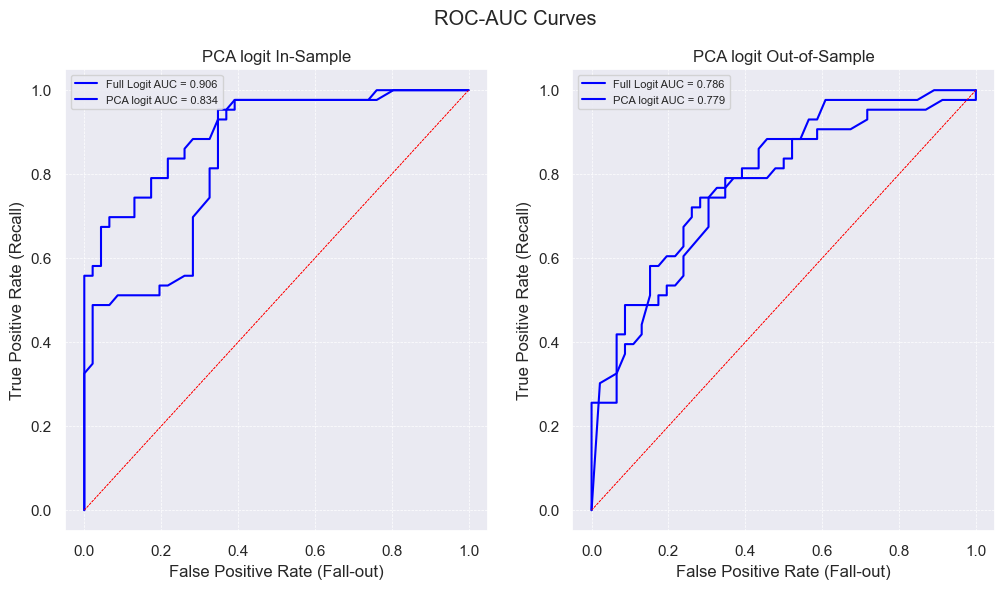

In [61]:
all_var = ['Constant', 'tdta', 'reta', 'opita', 'ebita', 'lsls', 'lta', 'gempl', 'invsls', 'nwcta', 'cacl', 'qacl', 'fata', 'ltdta', 'mveltd']
pca_var = ['Constant', 'lsls', 'lta', 'opita', 'nwcta', 'mveltd', 'tdta', 'reta']

models = [full_logit_model, pca_logit_model]
model_names = ['Full Logit', 'PCA logit']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

for model, name, var in zip(models, model_names, [all_var, pca_var]):
    for x_frame, y_frame, axis in zip([x_train, x_test], [y_train, y_test], fig.axes):
        predicted_probabilities = model.predict(x_frame[var])

        tpr = []
        fpr = []
        for threshold in np.linspace(0, 1, 100):
            y_hat = [1 if x > threshold else 0 for x in predicted_probabilities]

            TP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            FP = sum((y_hat[i] == 1) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))
            FN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 1) for i in range(len(y_frame)))
            TN = sum((y_hat[i] == 0) and (y_frame.iloc[i] == 0) for i in range(len(y_frame)))

            tpr.append(TP / (TP + FN))
            fpr.append(FP / (FP + TN))

        score = roc_auc_score(y_frame, predicted_probabilities)
        axis.plot(fpr, tpr, label=f'{name} AUC = {score:.3f}', color='blue', alpha=1)
        axis.plot([0, 1], [0, 1], ls='--', lw=0.5, color='red')
        axis.set(xlim=(-0.05, 1.05), ylim=(-0.05, 1.05))
        axis.grid(ls='--', lw=0.5)
        axis.set_ylabel('True Positive Rate (Recall)')
        axis.set_xlabel('False Positive Rate (Fall-out)')
        if (x_frame.values == x_train.values).all():
            axis.set_title(f'{name} In-Sample')
        else:
            axis.set_title(f'{name} Out-of-Sample')
        axis.legend(loc='best', fontsize=8)
fig.suptitle('ROC-AUC Curves')
plt.show()

Text(0.5, 1.0, 'Confusion Matrix with PCA logit')

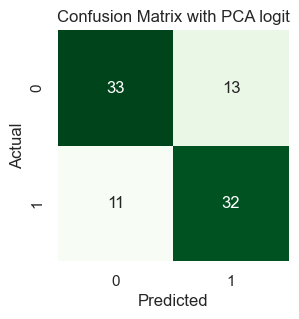

In [62]:
from sklearn.metrics import confusion_matrix

predicted_probs = pca_logit_model.predict(sm.add_constant(x_test[pca_var]))
predicted_classes = (predicted_probs >= 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", square=True, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with PCA logit')

Aside from using all the explanatory variables, this is the higher out-of-sample AUC we have achieved so far. 0.779 is higher than the 0.771 we achieved with our variables chosen purely by simpele correlation. We are closer to the logit using all the explanatory variables, but perhaps this advantage would subside a little when using a larger dataset.

Overall, the logit models haven't performed incredible well but are still strong enough in their predictions to classify most firms in the test dataset correctly (73%). They are good models and still do an arguably good job out of sample considering the fact that they were trained with only 89 observations. It will be interesting to compare to some of the machine learning models in the following sections.

### 22. Propose practical changes to the STATA, SAS, PYTHON or R code (if any).
Python is an excellent language for a beginner. It has a very readable syntax which makes it easy to figure out what the code does and also makes it more difficult to forget how to code the language. One thing I do not like about python is the error messages can be very unenlightening. Sometimes a simple mistake in the code can create error messages that are very unintuitive and can be difficult to figure out. There are libraries you can install to assist with the error messages but overall I find C's error messages easier to understand and rectify. While it is easier to code without declaring a variable, I find explicitly declaring a type in C useful (you would say int, float, double) to declare a variable type. It also reduces the incidence of run-time errors.

### 23. Additional question: create or generate a dummy equal to one for non-default firms named ynd, using the command “ynd=1-yd”. Then do the following OLS regressions with TDTA (total debt over total assets) as the dependent variable and comment the results:
1) Tdta regressed on yd, ynd with common intercept
2) Tdta regressed on yd and common intercept (on the slides)
3) Tdta regressed on ynd and common intercept
4) Tdta regressed on yd, ynd with common intercept and the restriction that the sum
of parameters of yd and ynd are equal to zero.
In time-series cross sections, we have one index for individuals and one index for time. What would be the analogy correspondence for “between-groups” when considering individual index and time index with the index for a group and another index for individuals within a group?

In [63]:
model = sm.regression.linear_model.OLS(x['tdta'], sm.add_constant(y), hasconst=True).fit()
print('T-Test Recovered from Linear Probability Regression: x = α + βy + ϵ')
print('H0: β = 0')
print(f'T-statistic: {model.tvalues[1]:0.3f}')
print(f'P-value: {model.pvalues[1]:0.3f}')
print(model.summary())

T-Test Recovered from Linear Probability Regression: x = α + βy + ϵ
H0: β = 0
T-statistic: 6.124
P-value: 0.000
                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

For convenience, I have displayed the regression table for 
$$ 
default_i = β_0 + β_1(\frac{total debt}{total assets})_i  + ε_i
$$

Now, we will create the variable ynd which is just $1 - yd$

In [64]:
df3 = df2.copy()

In [65]:
df3['ynd'] = 1 - df3['yd']

In [66]:
df3.head()

,yd,tdta,reta,opita,ebita,lsls,lta,gempl,invsls,nwcta,cacl,qacl,fata,ltdta,mveltd,ynd
0,0,0.409262,0.006859,0.126605,0.098086,2.968233,3.158393,0.160371,0.162727,0.341705,2.264987,1.766896,0.139137,2.755766,0.226291,1
1,0,0.196958,0.011139,0.221797,0.200671,4.025514,3.827649,0.205517,0.158391,0.595541,4.319132,3.243222,0.001032,27.631832,0.162987,1
2,0,0.221871,0.025861,0.163300,0.101795,3.893146,4.349449,0.319319,0.197563,0.574539,5.850013,4.793296,0.103410,8.314004,0.286059,1
3,0,0.672715,0.035095,-0.051201,-0.079017,4.102660,3.351699,-0.054518,0.167411,0.230967,1.453028,0.757208,0.066603,0.347517,0.255442,1
4,0,0.711649,0.036947,0.163827,0.133554,5.523118,5.194734,0.079608,0.135278,0.175058,1.536597,0.960747,0.270561,0.716692,0.410125,1


In [67]:
df3['Constant'] = 1

### 23. Additional question: create or generate a dummy equal to one for non-default firms named ynd, using the command “ynd=1-yd”. Then do the following OLS regressions with TDTA (total debt over total assets) as the dependent variable and comment the results:

#### 1) Tdta regressed on yd, ynd with common intercept

In [68]:
mod1 = sm.OLS(df3['tdta'], df3[['ynd', 'yd', 'Constant']], hasconst=True).fit()

In [69]:
print(mod1.summary())

                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ynd            0.0960      0.016      6.099      0.0

Mod1 is the regression of total debt/total assets on default and nondefault (= 1 - default)
$$
tdta_i = β_0 + β_1 * ynd_i + β2 * yd_i + ε_i 
$$
naturally, we expect perfect collinearity because one variable is simply 1 - the other. We will not succeed in extracting any explanatory power from a variable that can be directly calculated from another or is 0 when the other is 1 and vice versa. In the notes on the regression table we see that the smallest eigenvalue is 2.66e-30 suggesting strong multicollinearity.

A model estimated with collinearity makes it difficult to disentangle the effect of ynd and yd on tdta. The β parameters will not be identified. This is not a data problem however, it is an issue with the selection of variables and whenever we have one explanatory variable as a linear combination of another - just choose one! 

In [70]:
corr = df3[['ynd', 'yd']].corr()
print(corr)

     ynd   yd
ynd  1.0 -1.0
yd  -1.0  1.0


Observe the correlation matrix and the correlation is -1. There is perfectly negative correlation.

#### 2) Tdta regressed on yd and common intercept (on the slides)

This is mod2 and has us regress total debt/total assets on the 'explanatory variable' default:
$$
tdta_i = β_0 + β_1 * yd_i + ε_i 
$$
This model will avoid the issues of perfect collinearity we saw in the model above and treats tdta as the dependent variable and the binary default variable as the explanatory variable.

Let us recall the LPM model and estimate the LPM model for yd on tdta using the full dataset (without the missing observations). The results will be different to the LPM estimated above because we estimated it with the train dataset.

In [71]:
LPMrecall = sm.OLS(df3['yd'], df3[['tdta', 'Constant']], hasconst=True).fit()
print(LPMrecall.summary())

                            OLS Regression Results                            
Dep. Variable:                     yd   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                -111.90
No. Observations:                 178   AIC:                             227.8
Df Residuals:                     176   BIC:                             234.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tdta           0.9504      0.155      6.124      0.0

And now we will estimate mod2 as specified above

In [72]:
mod2 = sm.OLS(df3['tdta'], df3[['yd', 'Constant']], hasconst=True).fit()
print(mod2.summary())

                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yd             0.1848      0.030      6.124      0.0

This models estimate as:
$$
LPMrecall:    yd_i = -0.0512 + 0.9504 * tdta_i + ε_i 
$$ 
$$
Mod2:     tdta_i = 0.4729 + 0.1848 * yd + ε_i 
$$

We can interpret mod 2 as follows. The constant term will estimate tdta when yd=0. In other words, this will be the mean of tdta for non-defaulting firms. confirmed below:

In [73]:
df3.loc[df3['yd'] == 0, 'tdta'].mean()

0.4729464652173913

we can also interpret from mod2 the mean tdta for defaulting firms. Let yd=1 and estimate the model
tdta = 0.4729 + 0.1848 = 0.6577. Let us confirm:

In [74]:
df3.loc[df3['yd'] == 1, 'tdta'].mean()

0.6577883860465116

This means that we can interpret the coefficnt $β_1$ as the difference in means of tdta between defaulting and healthy firms. The same as we saw long ago in question 5.

#### 3) Tdta regressed on ynd and common intercept

In [75]:
mod3 = sm.OLS(df3['tdta'], df3[['ynd', 'Constant']], hasconst=True).fit()
print(mod3.summary())

                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ynd           -0.1848      0.030     -6.124      0.0

This regression estimates:
$$
tdta_i = β_0 + β_1 * ynd_i + ε_i 
$$

and yields the LPM
$$
mod3:    tdta_i = 0.6578 - 1.848 * ynd_i + ε_i
$$

$$ 
Mod2:     tdta_i = 0.4729 + 0.1848 * yd + ε_i 
$$

The difference between mod2 and mod3 is very clear. Because ynd is just 1 - yd, instead of the intercept being the mean of tdta when yd=0, it is the mean of tdta when yd=1 which is the same as ynd=0. We see a reversal in the interpretation because the constant swaps places with mod2's tdta when yd=1 and the coefficient on ynd remains the difference in means between healthy and defaulted firms, but the sign changes.

#### 4) Tdta regressed on yd, ynd with common intercept and the restriction that the sum of parameters of yd and ynd are equal to zero.


We can impose this constrain by replacing the parameter for yd with the negative of the parameter for ynd.

In [76]:
df3['ydctr'] = df3['yd'] - df3['yd'].mean()
df3['yndctr'] = df3['ynd'] - df3['ynd'].mean()
mod4 = sm.OLS(df3['tdta'], df3[['ydctr', 'yndctr', 'Constant']], hasconst=True).fit()
print(mod4.summary())

                            OLS Regression Results                            
Dep. Variable:                   tdta   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     37.51
Date:                Mon, 09 Oct 2023   Prob (F-statistic):           5.78e-09
Time:                        10:12:53   Log-Likelihood:                 33.834
No. Observations:                 178   AIC:                            -63.67
Df Residuals:                     176   BIC:                            -57.30
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ydctr          0.0924      0.015      6.124      0.0

In [77]:
df3['yd'].mean()

0.48314606741573035

Recall the mean tdta for healthy firms is 0.4729464652173913 and for defaulting 0.6577883860465116. Let us also remember the estimated model from 23.1:
$$
mod1:   tdta_i = 0.3769 + 0.0960 * ynd_i + 0.2809 * yd_i + ε_i 
$$
and now for mod4
$$
mod4:   tdta_i = 0.5623 + 0.0924 * ydctr_i + -0.0924 * yndctr_i + ε_i 
$$

When we estimate model for for a defaulting firm we get $tdta = 0.6523 + 0.0924*1 - 0.0924*0 = 0.6547$ which is close to the mean tdta for the defaulting group: 0.6577883860465116.

Similarly, when we estimate for non-defaulting firms we get $tdta = 0.6523 + 0.0924*0 - 0.0924*1 = 0.4699$ which is almost the same as the mean tdta for healthy firms: 0.4729464652173913.

What we have done with this model is require that the effect of default translated into the model by yd is the same but opposite to that of ynd. So we have averaged the effect of default/non-default so has the same marginal effect when it goes both ways which using these perfectly collinear explanatory variables. Ordinarily you would estimate a model with this constraint on the parameters if you were estimating the relative impact of being in two groups while requiring that they have 0 impact on the dependent.

#### In time-series cross sections, we have one index for individuals and one index for time. What would be the analogy correspondence for “between-groups” when considering individual index and time index with the index for a group and another index for individuals within a group?

In time series cross sections there are two types of data: we have the cross section reflected in the changes between individuals, and the time series or within which reflect changes of an individual over time. With panel data, the between estimator uses time averages for all variables, $x_(i,t)$ and $y_(i,t)$ and estimates
$$
\bar{y}_i = β_0 + β_1 * \bar{x_i} + ε_i $$
It estimates with the between variation (between individuals) averaged over time.

When we do not have a time component, but instead have a group and individual subscript, we can estimate the between estimator using the variation between the groups. So, with our groups being default and healthy, we can average these groups and estimate
$$
\bar{y}_i = β_0 + β_1 * \bar{x_i} + ε_i $$
where i represent healthy or default. We average not across time and have i reflect the individuals, we average across group and have i reflect the group. In this way, if we estimate
$$
\bar{tdta}_i = β_0 + β_1 * \bar{yd_i} + ε_i $$
then the constant term is the average total debt/total assets for the non-defaulting group, and $β_1$ reflects the difference in tdta between the defaulters and the healthy firms.